
# Predicting a Movie's Success Through IMDB Features and Reviews
# 15-288 Final Project: Data Preparation
## By Boushra Bendou and Jullia Montejo

### This project focuses on building a model that given a number of movie reviews that are written within a month of the release date (both before and after) it predicts the success of a movie which is represented by the total box office earnings worldwide.  

# 1 Data Collection

We employed web scraping modules such as BeautifulSoup and requests to gather data, specifically information about a movie and it's user reviews from IMDB's website.

In [1]:
pip install beautifulsoup4


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install torch

In [6]:
!pip install torch torchvision torchaudio

In [7]:
pip install forex-python

Note: you may need to restart the kernel to use updated packages.


### Request Function

In [8]:
from bs4 import BeautifulSoup
import requests
import time
import random
from datetime import datetime

# Function to make requests with delay and headers
def make_request(url):
    headers = {
        'User-Agent': 'Chrome/58.0.3029.110'}
    response = requests.get(url, headers=headers)
    time.sleep(random.uniform(1, 3))
    return response

### Scraping Movie Information

We first stored all available information about a movie from its IMDB page in its corresponding dictionary.

In [9]:
# Helper function to change date information into datetime format.
def format_date(date_string):
    date_string = date_string.split(' (')[0]
    try:
        date = datetime.strptime(date_string, '%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(date_string, '%B %Y')
        except ValueError:
            return 'n/a'

    # Format the date as dd/mm/yyyy
    formatted_date = date.strftime("%d/%m/%Y")
    return formatted_date

In [10]:
from datetime import datetime

def scrape_movie_info(url):
    response = make_request(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # print(soup.prettify())

    # Initialize variables
    release_date = 'N/A'
    directors = []
    writers = []
    country_of_origin = []
    company = []
    languages = []
    genres = []
    top_stats = {'release_year': 'N/A', 'rated': 'N/A', 'runtime': 'N/A'}
    review_stats = {'user reviews': 'n/a', 'critic reviews': 'n/a', 'metascore': 'n/a'}
    box_stats = {'budget': 'n/a', 'opening weekend us & canada': 'n/a', 'gross us & canada': 'n/a', 'gross worldwide': 'n/a'}

    # Get movie title.
    title_element = soup.find('span', {'class': 'hero__primary-text'})
    title = title_element.text.strip() if title_element else 'N/A'
    # print(title)

    # Get movie release year.
    year_element = soup.find('span', id='titleYear')
    year_element = year_element.text.strip() if year_element else 'N/A'

    div_tag = soup.find('div', {'class': 'sc-b7c53eda-0 dUpRPQ'})
    if div_tag is not None:
        li_tag = div_tag.find_all('li', {'role': 'presentation', 'class':'ipc-inline-list__item'})
        for li in li_tag:
            a = li.find_all('a')
            for link in a:
                if link.get('href'):
                    # print(a)
                    if 'releaseinfo' in link.get('href'):
                        top_stats['release_year'] = link.text.strip()
                    elif 'parentalguide' in link.get('href'):
                        # print('here')
                        top_stats['rated'] = link.text.strip()
            else:
                top_stats['runtime'] = li.text.strip()
    # print(top)

    # Get IMDb rating
    rating_span_tag = soup.find('span', {'class': 'sc-bde20123-1 cMEQkK'})
    rating = rating_span_tag.text.strip() if rating_span_tag else 'N/A'

    # Get number of IMDb ratings
    rating_count = soup.find('div', {'class': 'sc-bde20123-3 gPVQxL'})
    rating_count = rating_count.text.strip() if rating_count else 'N/A'

    # Get number of user and critic reviews
    ul_tag_rvw = soup.find('ul', {'class':'ipc-inline-list sc-9e83797f-0 jflJlf baseAlt'})
    if ul_tag_rvw is not None:
        li_tag_rvw = ul_tag_rvw.find_all('li', {'role':'presentation', 'class':'ipc-inline-list__item sc-9e83797f-1 cxyOpW'})

        for li in li_tag_rvw:
            if 'user reviews' in li.text.lower():
                scores = li.find('span', {'class':'score'})
                review_stats['user reviews'] = scores.text.strip()
            elif 'critic reviews' in li.text.lower():
                scores = li.find('span', {'class':'score'})
                review_stats['critic reviews'] = scores.text.strip()
            elif 'metascore' in li.text.lower():
                scores = li.find('span', {'class':'score'})
                review_stats['metascore'] = scores.text.strip()
    # print(review_stats)

    # Find the a tag with the specific class
    div_tag = soup.find('div', {'class': 'ipc-chip-list__scroller'})
    if div_tag is not None:
        a_tags = div_tag.find_all('a', {'class': 'ipc-chip ipc-chip--on-baseAlt'})
        genres = [a.text.strip() for a in a_tags]
    else:
        genres = []
    # print(genres)

    # Get box office stats.
    box_section = soup.find('section', {'class': 'ipc-page-section ipc-page-section--base celwidget', 'data-testid': 'BoxOffice'})
    if box_section is not None:
        box_div = box_section.find('div', {'class': 'sc-f65f65be-0 bBlII'})
        box_tag = box_div.find_all('li', {'class': 'ipc-metadata-list__item sc-1bec5ca1-2 bGsDqT'})

        for each in box_tag:
            if each.find('span', {'class': 'ipc-metadata-list-item__list-content-item'}):
                if 'budget' in each.text.lower():
                    content = each.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                    box_stats['budget'] = content.text.strip()
                elif 'opening weekend us & canada' in each.text.lower():
                    content = each.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                    box_stats['opening weekend us & canada'] = content.text.strip()
                elif 'gross us & canada' in each.text.lower():
                    content = each.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                    box_stats['gross us & canada'] = content.text.strip()
                elif 'gross worldwide' in each.text.lower():
                    content = each.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                    box_stats['gross worldwide'] = content.text.strip()

    # Find all hyperlinks in the page.
    all_links = soup.find_all('a', {'class': 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})

    # Iterate over the links
    for link in all_links:
        # print(link)
        # Get release date, list of directors, writers, country of origin, languages, and production company.
        if 'releaseinfo' in link.get('href', ''):
            release_date = link.text.strip()
            release_date = format_date(release_date)
        elif 'tt_cl_dr_1' in link.get('href', ''):
            directors += [link.text.strip()]
        elif 'tt_cl_wr' in link.get('href', ''):
            writers += [link.text.strip()]
        elif 'country_of_origin' in link.get('href', ''):
            country_of_origin += [link.text.strip()]
        elif 'primary_language' in link.get('href', ''):
            languages += [link.text.strip()]
        elif 'company' in link.get('href', ''):
            company += [link.text.strip()]

    info_dict = {'title': title, 'release_date': release_date, 'release_year': top_stats['release_year'], 'rated': top_stats['rated'], 'runtime': top_stats['runtime'],
            'directors': directors, 'writers': writers, 'country_of_origin': country_of_origin, 'languages': languages,
            'production_company': company, 'imdb_rating': rating, 'number_of_ratings': rating_count,
            'number_of_user_reviews': review_stats['user reviews'], 'number_of_critic_reviews': review_stats['critic reviews'], 'metascore': review_stats['metascore'],
            'genres': genres, 'budget': box_stats['budget'], 'opening_weekend_us_and_canada': box_stats['opening weekend us & canada'],
            'gross_us_and_canada': box_stats['gross us & canada'], 'gross_worldwide': box_stats['gross worldwide']}

    return info_dict

### Generating Movie URLS

We generated a total of 100 movie urls from each genre by storing the urls of 50 high-rated and 50 low-rated movies from each genre in a list. Scraping from the IMDB genre page, there are a total of 23 genres. However, we left out the "Short" genre as it is empty and the "Film-Noir" genre as these movies' release dates are too old. As our project focuses on predicting the success of movies based on early reviews, we only scraped movies that are released from January 1999 to March 2024. We chose January 1999 as our start year as IMDB launched its user reviews feature during this year, after its acquisition by Amazon in 1998.


In [11]:
# This function stores all the available movie genres from IMDb in a list.
def get_movie_genres(url):
    response = make_request(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    genres = []
    # Find movie genre section and get all movie genres
    genre_section = soup.find_all('section', {'class': 'ipc-page-section ipc-page-section--base'})
    genre_tags = genre_section[1].find_all('a', {'class': 'ipc-chip ipc-chip--on-base-accent2'})
    genres = [a.text.strip() for a in genre_tags]

    # Remove genres as they are empty.
    genres.remove('Film-Noir')
    genres.remove('Short')

    return genres

In [12]:
# This function gets all the movie URLs from an IMDb genre page.
def get_movie_urls(url):
    response = make_request(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = []
    movie_tags = soup.find_all('a', {'class': 'ipc-title-link-wrapper'})
    for tag in movie_tags:
        urls.append('https://www.imdb.com' + tag['href'])
    # print(urls)
    return urls

In [13]:
# This function generates the URL for the review page of a given movie.
def get_review_url(url):
    cut_url = url.split('/?ref')[0]
    return cut_url + '/reviews?spoiler=hide&sort=submissionDate&dir=asc&ratingFilter=0'

In [14]:
# This function gets 50 high-rated and 50 low-rated movie URLs for each genre and stores them in a list.
def get_all_movie_urls():
    genres = get_movie_genres('https://www.imdb.com/feature/genre/?ref_=nv_ch_gr')

    all_urls = []
    for genre in genres:
        # High-rated movies
        genre_url = f'https://www.imdb.com/search/title/?genres={genre.lower()}&explore=genres&title_type=feature&release_date=1999-01-01,2024-03-31&user_rating=5.6,10&sort=num_votes,desc'
        urls1 = get_movie_urls(genre_url)

        # Low-rated movies
        genre_url = f'https://www.imdb.com/search/title/?genres={genre.lower()}&explore=genres&title_type=feature&release_date=1999-01-01,2024-03-31&user_rating=1,5.5&sort=num_votes,desc'
        urls2 = get_movie_urls(genre_url)

        all_urls += urls1
        all_urls += urls2
    return all_urls

all_movie_urls = get_all_movie_urls()

### Scraping IMDB Movie Reviews

We scraped 20 IMDB reviews from each movie, with each review being within 30 days (before and after) of the movie's release date. Selenium was used for this step of scraping as we needed to simulate real user actions such as clicking the 'load more' button on the review page to be able to load and scrape more reviews.

In [15]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from datetime import datetime


def scrape_movie_reviews(url, release_date):
    review_dict = []
    click_count = 0

    # Convert release_date to datetime object
    if release_date.lower() != 'n/a':
        release_date = datetime.strptime(release_date, '%d/%m/%Y')
    else:
        release_date = None

    # Prevent the popup browser from opening
    chrome_options = Options()
    chrome_options.add_argument("--headless")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    try:
        while click_count < 10 and len(review_dict) < 20:
            # Wait until the load more button in the review page is clickable.
            load_more_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.ID, 'load-more-trigger'))
            )

            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element((By.CSS_SELECTOR, 'obscuring-element-selector'))
            )
            load_more_button.click()
            click_count +=1

            # Wait for the reviews to load before scraping the page source
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'div.lister-item.mode-detail.imdb-user-review'))
            )

            # Get the updated page source after clicking the button
            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Find all review containers
            review_containers = soup.select('div.lister-item.mode-detail.imdb-user-review.with-spoiler, div.lister-item.mode-detail.imdb-user-review.collapsable')

            # Iterate over the review containers and store the date and review in a dictionary
            for each in review_containers:
                date = each.select_one('span.review-date').text.strip()
                date = datetime.strptime(date, '%d %B %Y')
                # print("reviewed: ", date)
                # print("release: ", release_date)
                if release_date is not None and (date <= release_date or (release_date < date <= release_date + timedelta(days=30))):
                    # print('yes')
                    review = each.select_one('div.text.show-more__control').text.strip()
                    title = each.select_one('a.title').text.strip()
                    review_data = {
                        'review_date': date.strftime('%B %d, %Y'),
                        'review': review,
                        'review_title': title
                    }
                    if review_data not in review_dict:
                        review_dict.append(review_data)
                        if len(review_dict) >= 20:
                            break
                else:
                    click_count = 10
                    break
    except TimeoutException:
        pass
    finally:
        driver.quit()

    return review_dict

### Saving Scraped Dataset

In [16]:
import csv

# Function to save the movie data and reviews to a CSV file
def save_to_csv(movie_data_list, reviews_data_list, csv_filename):
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:  # Open the file in append mode
        fieldnames = list(movie_data_list[0].keys()) + ['review_date', 'review', 'review_title']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Check if the file is empty before writing the header
        if csvfile.tell() == 0:
            writer.writeheader()

        # Write the data to the CSV file
        for movie_data, reviews in zip(movie_data_list, reviews_data_list):
            for review in reviews:
                # Combine the movie data with the review data for each row.
                row = {**movie_data,
                    'review_date': review.get('review_date', 'N/A'),
                    'review': review.get('review', 'N/A'),
                    'review_title': review.get('review_title', 'N/A')}
                writer.writerow(row)

As there are 2100 movie urls, we need to parallelize the processing of multiple movies simulataneously. We used ThreadPoolExecutor for this process.


In [19]:
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta

def process_movie(url):
    # Scrape movie information
    movie_info = scrape_movie_info(url)
    # print(movie_info)
    time.sleep(1)

    # Scrape movie reviews
    review_url = get_review_url(url)
    reviews = scrape_movie_reviews(review_url, movie_info['release_date'])
    time.sleep(1)

    reviews_data = [{'review_date': review['review_date'], 'review': review['review'], 'review_title': review['review_title']} for review in reviews]

    return movie_info, reviews_data


# Initialize lists to store movie data and reviews data
movie_data = []
all_reviews_data = []
count = 0

with ThreadPoolExecutor(max_workers=15) as executor:
    # Use the executor to process multiple movies in parallel
    futures = {executor.submit(process_movie, url) for url in all_movie_urls}

    # Iterate over the completed futures
    for future in as_completed(futures):
        count += 1
        movie_info, reviews_data = future.result()
        movie_data.append(movie_info)
        all_reviews_data.append(reviews_data)  # Append the list of reviews for the current movie
        # print(count)

# Save data to CSV
save_to_csv(movie_data, all_reviews_data, 'movie_reviews_dataset.csv')

### Other Scraping Functions

This function gets a list of the top production companies based on this [IMDB list](https://www.imdb.com/list/ls567506715/), where each of the companies on the list has produced at least 2 films in the IMDB top 250. This would be used later in feature engineering.

In [111]:
def get_production_list():
    response = make_request('https://www.imdb.com/list/ls567506715/')
    soup = BeautifulSoup(response.content, 'html.parser')

    list_description = soup.find('div', class_='list-description')
    a_tags = list_description.find_all('a')

    prod = []
    for a in a_tags[:-2]:
        prod.append(a.text)
        # print(a.text)
    return prod

production_companies_list = get_production_list()

## Data Cleaning

First let's load up our data

In [21]:
import pandas as pd
import re
import numpy as np

We scraped a total of 20017 Reviews. However, since our task is to predict a single movie's success we will grop these reviews by movie

In [22]:
file_path = 'movie_reviews_dataset.csv'
df = pd.read_csv(file_path)
aggregation_functions = {col: 'first' for col in df.columns if col not in ['review', 'review_title']}
aggregation_functions['review'] = list
aggregation_functions['review_title'] = list
df = df.groupby('title').agg(aggregation_functions)
df.reset_index(drop=True, inplace=True)

In [23]:
df.shape

(1067, 23)

In [24]:
df.head()

,title,release_date,release_year,rated,runtime,directors,writers,country_of_origin,languages,production_company,...,number_of_critic_reviews,metascore,genres,budget,opening_weekend_us_and_canada,gross_us_and_canada,gross_worldwide,review_date,review,review_title
0,(500) Days of Summer,07/08/2009,2009,PG-13,1h 35m,['Marc Webb'],"['Scott Neustadter', 'Michael H. Weber']",['United States'],"['English', 'French', 'Swedish']","['Searchlight Pictures', 'Watermark', 'Dune En...",...,351.0,76.0,"['Comedy', 'Drama', 'Romance']","$7,500,000 (estimated)","$834,501","$32,391,374","$60,801,288","January 19, 2009",[What a delightful film. From the opening scre...,[A delightfully refreshing take on romantic co...
1,10 Cloverfield Lane,11/03/2016,2016,PG-13,1h 43m,['Dan Trachtenberg'],"['Josh Campbell', 'Matt Stuecken', 'Damien Cha...",['United States'],['English'],"['Paramount Pictures', 'Bad Robot', 'Spectrum ...",...,539.0,76.0,"['Drama', 'Horror', 'Mystery']","$15,000,000 (estimated)","$24,727,437","$72,082,998","$110,216,998","March 09, 2016","[Two months ago, no one knew that 10 Cloverfie...","[10 Cloverfield Lane, A brilliant mystery that..."
2,10 Things I Hate About You,31/03/1999,1999,PG-13,1h 37m,['Gil Junger'],"['Karen McCullah', 'Kirsten Smith', 'William S...",['United States'],"['English', 'French']","['Touchstone Pictures', 'Mad Chance', 'Jaret E...",...,121.0,70.0,"['Comedy', 'Drama', 'Romance']","$30,000,000 (estimated)","$8,330,681","$38,178,166","$53,685,286","March 31, 1999","[I'll admit it, when I first went into the the...","[I thought it was very cute and sweet..., It w..."
3,"10,000 BC",07/03/2008,2008,PG-13,1h 49m,['Roland Emmerich'],"['Roland Emmerich', 'Harald Kloser']","['United States', 'South Africa']",['English'],"['Warner Bros.', 'Legendary Entertainment', 'C...",...,255.0,34.0,"['Action', 'Adventure', 'Drama']","$105,000,000 (estimated)","$35,867,488","$94,784,201","$269,784,201","February 20, 2008",[I saw this a few months ago at an advance scr...,"[Just okay, The worst Emmerich film I have see..."
4,102 Dalmatians,22/11/2000,2000,G,1h 40m,['Michael D Moore'],"['Dodie Smith', 'Kristen Buckley', 'Brian Regan']","['United States', 'United Kingdom']",['English'],"['Walt Disney Pictures', 'Cruella Productions'...",...,62.0,35.0,"['Adventure', 'Comedy', 'Family']","$85,000,000 (estimated)","$19,883,351","$66,957,026","$183,611,771","November 22, 2000",[I saw this movie at an advance showing the ot...,"[Cute and entertaining, Another buzz-cut from ..."


Next we have to clean our scraped data and reformat all columns that need reformatting. We do this by:
- converting the runtime to minutes
- converting dates to datetime type
- converting all financials to floats

In [25]:
def runtime_to_minutes(runtime_str):
    if 'h' in runtime_str and 'm' in runtime_str:
        hours, minutes = runtime_str.split('h')
        return int(hours) * 60 + int(minutes.strip('m'))
    elif 'h' in runtime_str:
        hours = runtime_str.split('h')[0]
        return int(hours) * 60
    elif 'm' in runtime_str:
        minutes = runtime_str.strip('m')
        return int(minutes)

def convert_to_datetime(date_str):
    try:
        return pd.to_datetime(date_str)
    except:
        return None

def convert_numbers(fin_str):
    if fin_str == '':
        return None
    if pd.isna(fin_str):
        return None
    # Remove any characters that are not digits, periods, or K, M, or B
    fin_str = re.sub(r'[^\d.KMB]', '', fin_str)
    # Initialize a multiplier for K, M, or B
    multiplier = 1
    # Check for the presence of K, M, or B and adjust the multiplier accordingly
    if fin_str.endswith('K'):
        multiplier = 1e3
        fin_str = fin_str[:-1]  # Remove the last character 'K'
    elif fin_str.endswith('M'):
        multiplier = 1e6
        fin_str = fin_str[:-1]  # Remove the last character 'M'
    elif fin_str.endswith('B'):
        multiplier = 1e9
        fin_str = fin_str[:-1]  # Remove the last character 'B'
    elif fin_str.startswith('B'):
        multiplier = 1e9
        fin_str = fin_str[1:]  # Remove the last character 'B'
    # Convert the number part to float and apply the multiplier, then convert to int
    return int(float(fin_str) * multiplier)


In [26]:
df['runtime'] = df['runtime'].apply(runtime_to_minutes)
#df['runtime']

In [27]:
df['number_of_user_reviews'] = df['number_of_user_reviews'].apply(convert_numbers)
#df['number_of_user_reviews']

In [28]:
df['release_date'] = df['release_date'].apply(convert_to_datetime)
#df['release_date']

/var/folders/6d/82lm6dh113d3dzhpbgts96tc0000gn/T/ipykernel_14625/2289561565.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


In [29]:
df['review_date'] = df['review_date'].apply(convert_to_datetime)
#df['review date']

In [30]:
df['opening_weekend_us_and_canada'] = df['opening_weekend_us_and_canada'].apply(convert_numbers)
#df['opening_weekend_us_and_canada']

In [31]:
df['gross_us_and_canada'] = df['gross_us_and_canada'].apply(convert_numbers)
#df['gross_us_and_canada']

In [32]:
df['gross_worldwide'] = df['gross_worldwide'].apply(convert_numbers)
#df['gross_worldwide']

In [33]:
df['number_of_ratings'] = df['number_of_ratings'].apply(convert_numbers)
#df['number_of_ratings']

### Converting the budgets to USD

There are movies where the budget is in currencies that are not USD. So, to normalize the budget column we will convert all the budgets to USD (which takes a bit of time)

In [34]:
pip install forex_python

Note: you may need to restart the kernel to use updated packages.


In [35]:
from forex_python.converter import CurrencyRates
def parse_currency(value):
    if value is None:
        return None, None
    # Removing commas and any text within parentheses
    cleaned_value = re.sub(r'[,\(\).].*', '', value).strip()
    # Regex to extract amount and currency symbol/code
    match = re.match(r'([\$€£CAD₺₹₱¥HUFBDTRUB]*)(\d+)', cleaned_value)
    if match:
        currency_symbol = match.group(1)
        amount = convert_numbers(value)
        # Map currency symbols to standard currency codes
        currency_map = {
            '$': 'USD',   # US Dollar
            '€': 'EUR',   # Euro
            '£': 'GBP',   # British Pound
            'CAD': 'CAD', # Canadian Dollar
            '₺': 'TRY',   # Turkish Lira
            '₹': 'INR',   # Indian Rupee
            '₱': 'PHP',   # Philippine Peso
            '¥': 'JPY',   # Japanese Yen
            'HUF': 'HUF', # Hungarian Forint
            'BDT': 'BDT', # Bangladeshi Taka
            'RUR': 'RUB'  # Russian Ruble (Note: The correct ISO code is RUB, not RUR)
        }
        currency_code = currency_map.get(currency_symbol, None)
        return amount, currency_code
    return None, None


def convert_to_usd(amount, currency):
    if currency == 'USD' or amount is None:
        return amount
    converter = CurrencyRates()
    try:
        usd_amount = converter.convert(currency, 'USD', amount)
        return usd_amount
    except Exception as e:
        print(f"Error converting from {currency}: {e}")
        return None
# Apply parsing function
parsed_data = df['budget'].apply(parse_currency)
df['amount'], df['currency'] = zip(*parsed_data)  # Unpacking after applying the function
df['amount_usd'] = df.apply(lambda row: convert_to_usd(row['amount'], row['currency']), axis=1)

In [36]:
df['budget'] = df['amount_usd']
df.drop(columns=['amount', 'currency', 'amount_usd'], errors='ignore', inplace=True)

# 2. Data Analysis

### Before we analyze our dataset, here is short description of each of our scraped features:
- **title**: The title of the movie.
- **release_date**: The date when the movie was released.
- **release_year**: The year when the movie was released.
- **rated**: The rating given to the movie (e.g., PG-13, R, etc.).
- **runtime**: The duration of the movie (in minutes).
- **directors**: A list of the director(s) of the movie.
- **writers**: A list of the writer(s) of the movie.
- **country_of_origin**: The country where the movie was produced.
- **languages**: A list of languages the movie is officially offered in.
- **production_company**: A list of production companies that produced the movie.
- **imdb_rating**: The IMDb rating of the movie.
- **number_of_ratings**: The number of ratings given to the movie on IMDb.
- **number_of_user_reviews**: The number of user reviews on IMDb for the movie.
- **number_of_critic_reviews**: The number of critic reviews on IMDb for the movie.
- **metascore**: The Metascore rating of the movie.
- **genres**: A list of genres to which the movie belongs.
- **budget**: The budget allocated for making the movie in USD.
- **opening_weekend_us_and_canada**: The opening weekend box office earnings in the US and Canada.
- **gross_us_and_canada**: The total box office earnings in the US and Canada.
- **gross_worldwide**: The total box office earnings worldwide.
- **review_date**: The date when the review was written.
- **review**: The content of the review.
- **review_title**: The title of the review.


In [37]:
df.describe()

,release_date,release_year,runtime,imdb_rating,number_of_ratings,number_of_user_reviews,number_of_critic_reviews,metascore,budget,opening_weekend_us_and_canada,gross_us_and_canada,gross_worldwide,review_date
count,1067,1067.000000,1066.000000,1067.000000,1.067000e+03,1067.000000,1061.000000,960.000000,9.210000e+02,9.230000e+02,9.310000e+02,1.007000e+03,1067
mean,2011-09-11 15:15:00.843486464,2011.082474,113.675422,6.213590,2.828761e+05,858.000000,227.619227,56.289583,6.483115e+07,2.810657e+07,1.007331e+08,2.295209e+08,2011-08-10 07:09:09.953139712
min,1999-01-10 00:00:00,1999.000000,49.000000,1.000000,1.600000e+03,28.000000,2.000000,1.000000,4.818894e+00,5.760000e+02,2.238000e+03,5.660000e+02,1999-02-01 00:00:00
25%,2006-06-10 00:00:00,2006.000000,96.000000,5.200000,4.900000e+04,209.500000,90.000000,38.000000,2.000000e+07,3.357630e+06,2.152385e+07,3.407446e+07,2006-06-05 12:00:00
50%,2011-08-07 00:00:00,2011.000000,109.000000,6.500000,1.320000e+05,540.000000,182.000000,57.000000,4.500000e+07,1.480181e+07,5.850410e+07,1.099064e+08,2011-06-11 00:00:00
75%,2017-01-12 00:00:00,2016.000000,127.000000,7.500000,4.195000e+05,1000.000000,332.000000,74.000000,9.200000e+07,3.516169e+07,1.319226e+08,2.869727e+08,2016-12-08 00:00:00
max,2024-03-14 00:00:00,2024.000000,255.000000,9.000000,2.900000e+06,11500.000000,1000.000000,98.000000,3.560000e+08,3.571150e+08,9.366622e+08,2.923706e+09,2024-03-14 00:00:00
std,NaN,6.485569,24.123542,1.565365,3.543151e+05,1087.299513,172.822152,21.098545,5.999525e+07,3.909628e+07,1.214632e+08,3.202063e+08,NaN


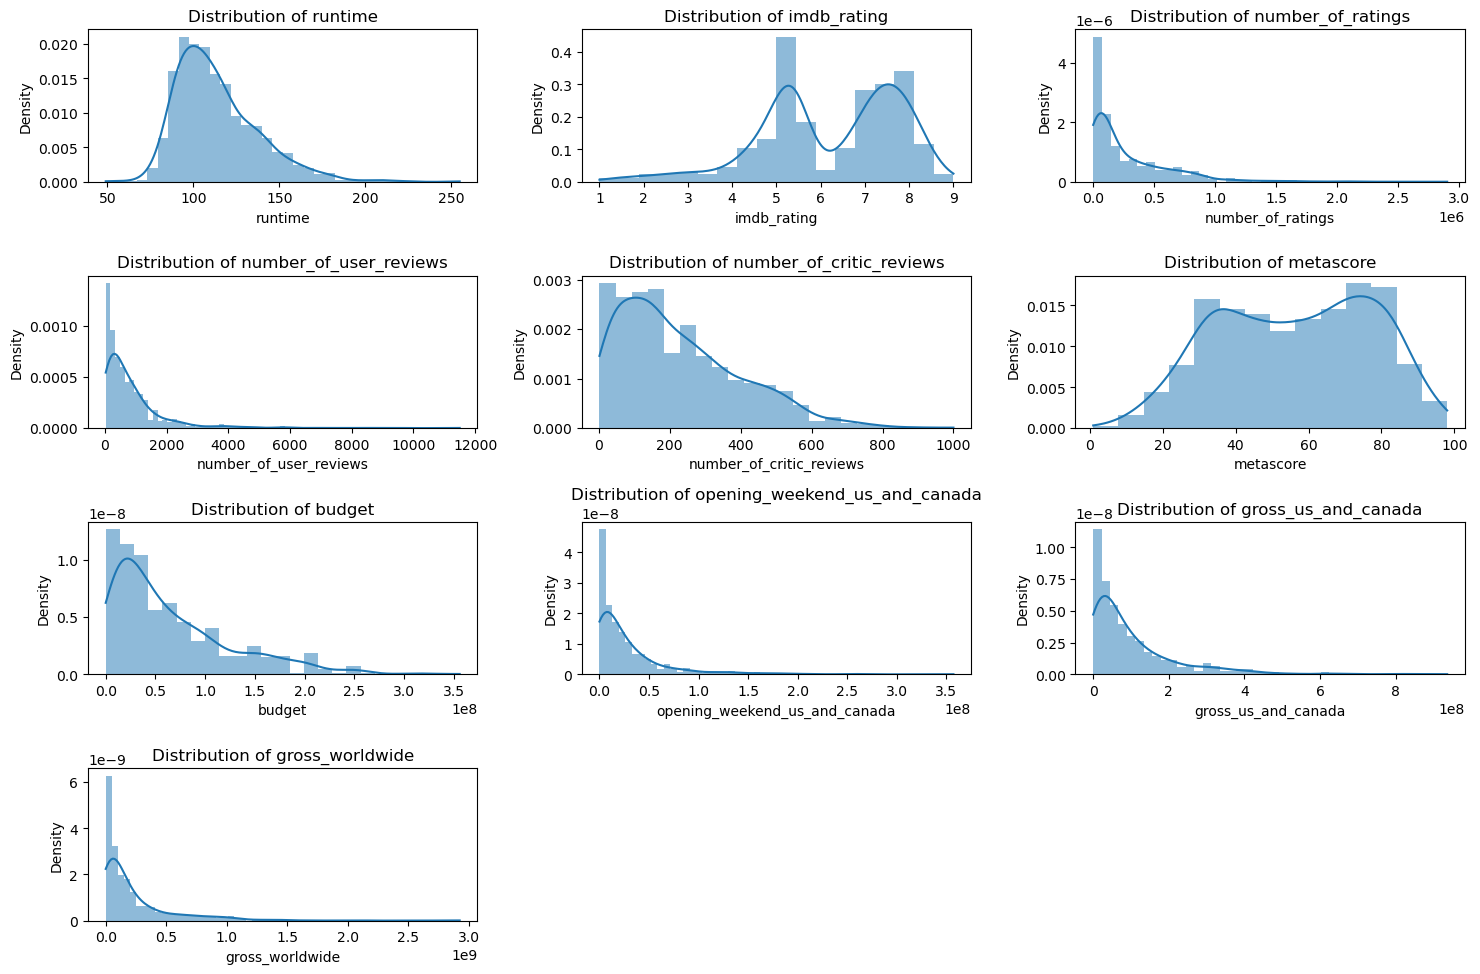

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure (adjust the size as needed)
plt.figure(figsize=(15, 10))

# List of numeric columns to plot
numeric_columns = [
    'runtime', 'imdb_rating', 'number_of_ratings',
    'number_of_user_reviews', 'number_of_critic_reviews',
    'metascore', 'budget', 'opening_weekend_us_and_canada', 'gross_us_and_canada', 'gross_worldwide'
]

# Plotting each numeric feature
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)  # Adjust grid parameters based on the number of plots
    sns.histplot(df[column], kde=True, stat="density", linewidth=0)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Lets take a closer look!

## Gross Revenue (Our Label)

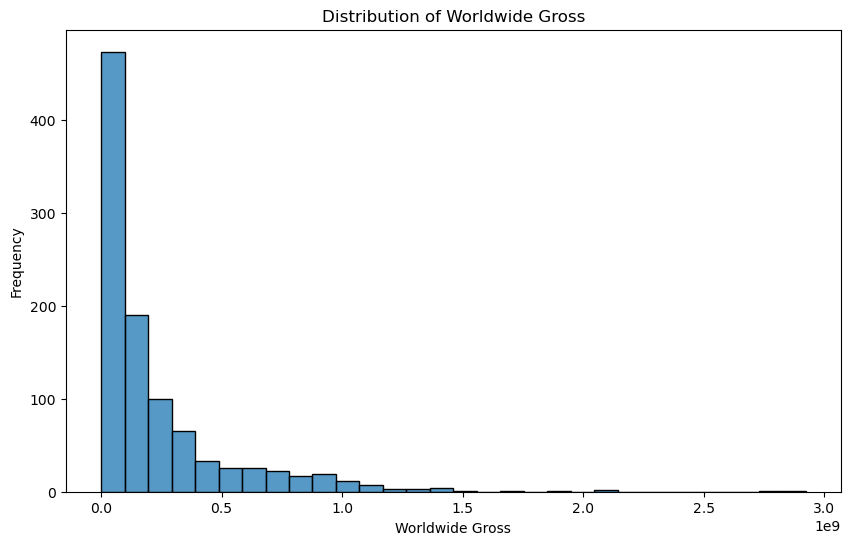

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df['gross_worldwide'].dropna(), bins=30, kde=False)
plt.title('Distribution of Worldwide Gross')
plt.xlabel('Worldwide Gross')
plt.ylabel('Frequency')
plt.show()


**Data Distribution:** The gross worldwide is right-skewed, meaning most movies earn a moderate amount in these categories, while a few outliers earn significantly more. There are several outliers, particularly for worldwide gross, indicating that a small number of movies have exceptionally high earnings compared to the rest. This could represent blockbuster hits.

Implications for our model:

- The presence of outliers suggests that predictive accuracy might vary widely across the dataset, and models might need to be robust or adjusted to account for the skewness in these financial variables.

**Choosing our label**
We are choosing this as our label as it is most suitable for all movies as there are many non US and Canada movies. We will also drop the other two gross features(**opening_weekend_us_and_canada and gross_us_and_canada**) as they reflect the same distribution and will be redundant


## IMDB Rating

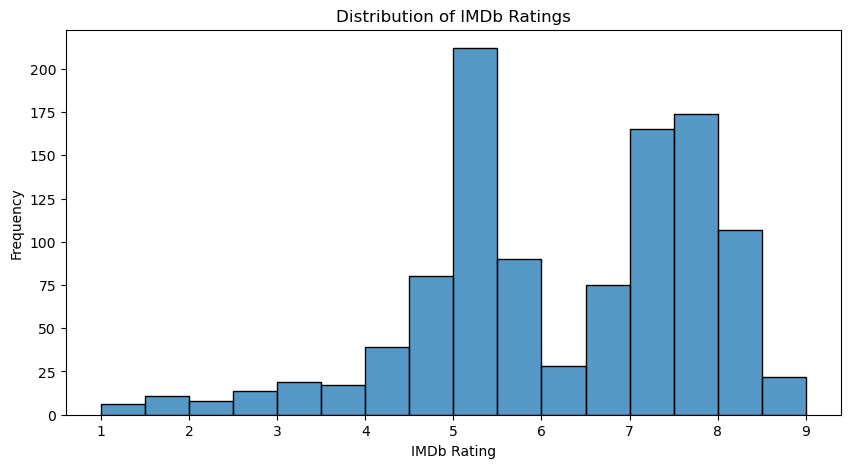

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['imdb_rating'], kde=False, bins=16)
plt.title('Distribution of IMDb Ratings')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.show()

 **Data Distribution:** The distribution is skewed to the right, suggesting most movies have ratings above the median, with fewer films rated very low or very high. The peak is around the 7-8 range, indicating a concentration of movies with good ratings.

**Data Imbalance:** There are fewer instances of extremely low or high-rated movies, which can lead to an imbalance in the dataset. Our model not perform well on predicting outliers, as it will be biased towards predicting ratings in the 6-8 range.

## Metascore

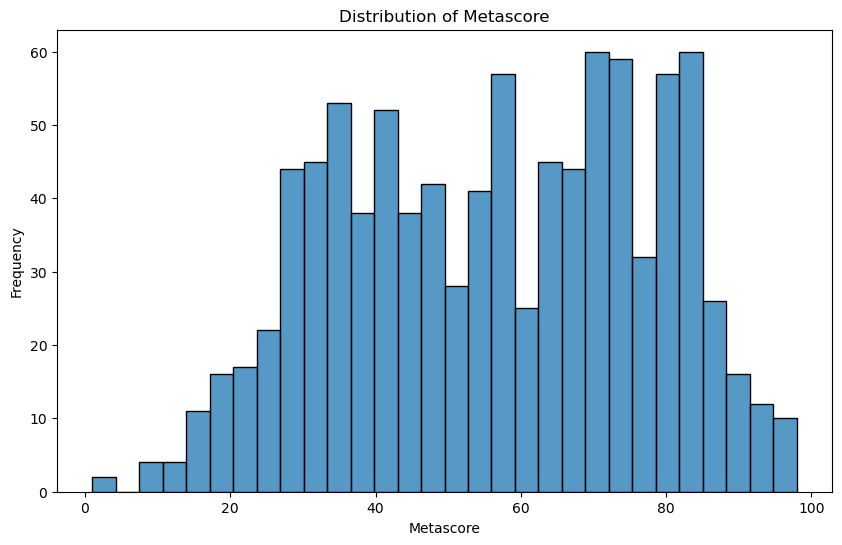

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df['metascore'].dropna(), bins=30, kde=False)
plt.title('Distribution of Metascore')
plt.xlabel('Metascore')
plt.ylabel('Frequency')
plt.show()

**Data Distribution:** The histogram of Metascores depicts a a way more normal distribution with a slight left skew, indicating that there are fewer movies with very low Metascores and a larger concentration of movies with scores around the middle to higher end of the scale.

Implications for our model:
- The model will have more data points to learn from for movies with average Metascores, potentially improving prediction accuracy in this range.

## IMDB Rating vs Metascore

We hypothesize that metascore and imdb_rating are highly correlated which means we might have to stick to one of them as a feature to reduce redundancy in our models

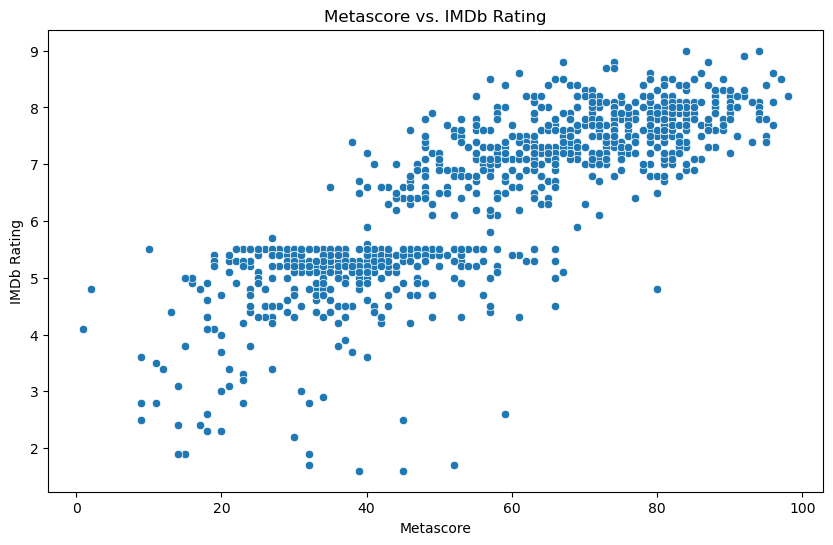

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='metascore', y='imdb_rating')
plt.title('Metascore vs. IMDb Rating')
plt.xlabel('Metascore')
plt.ylabel('IMDb Rating')
plt.show()

As expected, the IMDB Ratings and Metascore are highly correlated. Since the Metascore is more representative we can consider making it one of our features instead. However, for our task since the user will be more familiar with the IMDB rating of the movie we will most likely keep it as the featuure

**IMDb Ratings:** A user-based rating system that could be more reflective of the general audience's opinion but may be subject to biases, like users rating movies they like and not rating those they have no interest in.

**Metascore:**  A critic-based metric that aggregates various critic reviews and may provide a more standardized assessment of a movie's quality. However, it could be less reflective of the general audience's opinion.


## Number of Reviews (User and Critic)

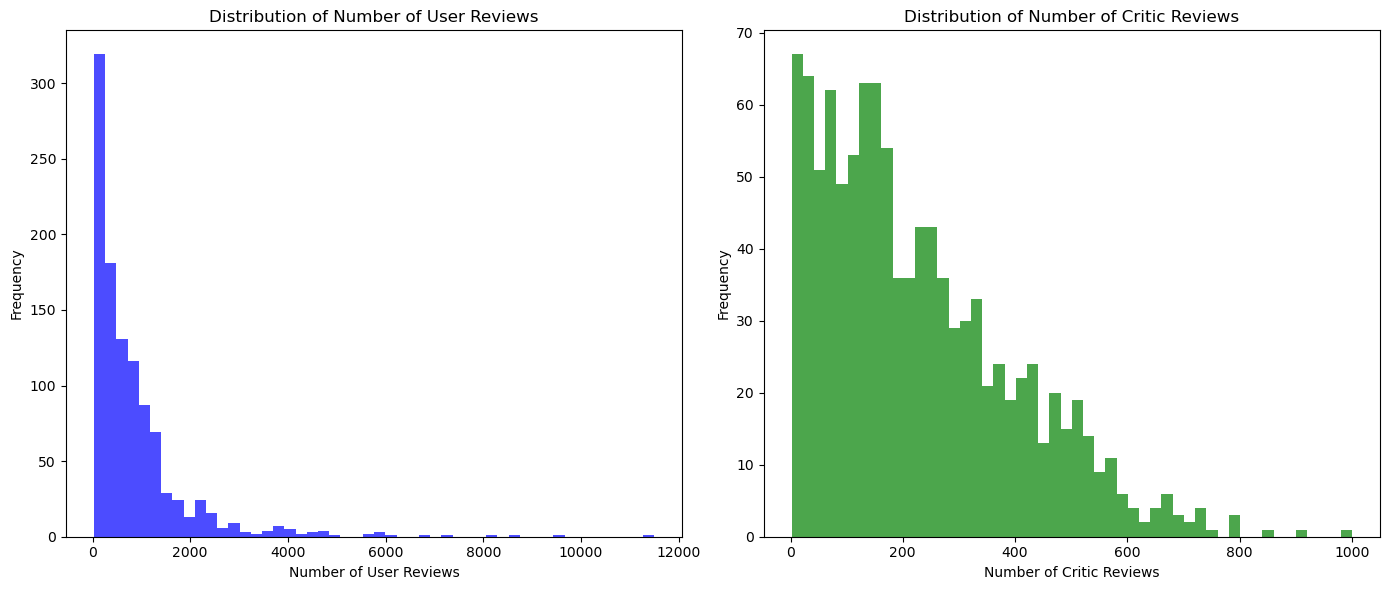

<Figure size 1400x600 with 0 Axes>

In [43]:
aggregated_data = df.groupby('title').agg({
    'number_of_user_reviews': 'max',
    'number_of_critic_reviews': 'max'
}).reset_index()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(aggregated_data['number_of_user_reviews'].dropna(), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Number of User Reviews')
plt.xlabel('Number of User Reviews')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(aggregated_data['number_of_critic_reviews'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Distribution of Number of Critic Reviews')
plt.xlabel('Number of Critic Reviews')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 6))

plt.tight_layout()
plt.show()

We hypothesize that the number of user reviews and the number of critic reviews are correlated because they both reflect the popularity of the movie

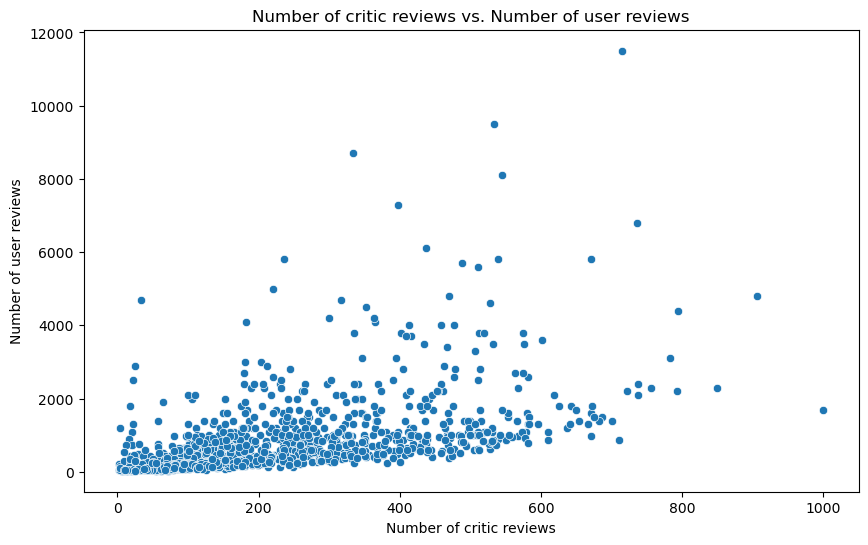

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_critic_reviews', y='number_of_user_reviews')
plt.title('Number of critic reviews vs. Number of user reviews')
plt.xlabel('Number of critic reviews')
plt.ylabel('Number of user reviews')
plt.show()

Our assumption was incorrect therefore we might have to consider keeping both as parameters. We can check whether to keep them later when we look at the full confusion matrix

### Number of User Reviews

**Distribution**: The histogram and box plot for user reviews indicate a highly right-skewed distribution. Most movies have a relatively small number of user reviews, with a few movies having an extremely high number, which appear as outliers on the box plot.

### Number of Critic Reviews

**Distribution**: The distribution of critic reviews is also right-skewed but less extreme compared to user reviews. There are outliers, but they are not as pronounced.

**It is unclear if either of these can be considered a parameter in predicting the movie success. Therefore we will assess their correlation with the Gross Worldwide Label**

## Runtime

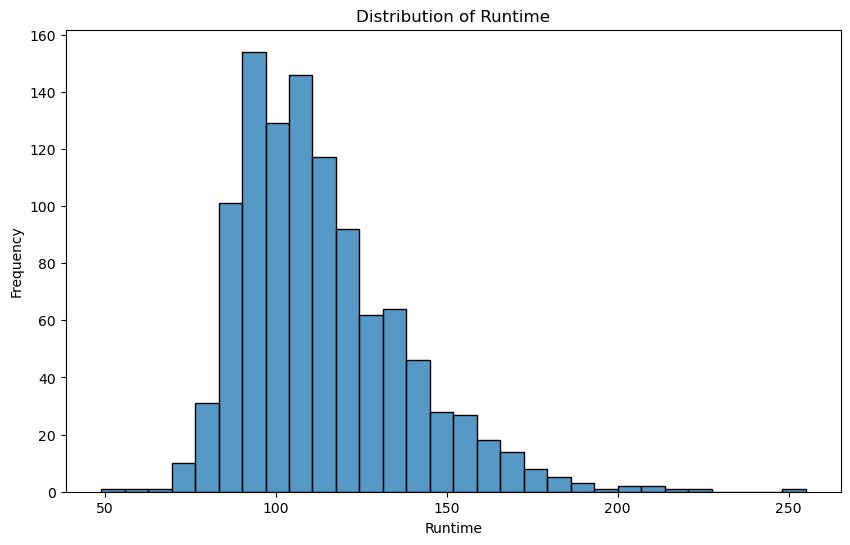

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df['runtime'].dropna(), bins=30, kde=False)
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.show()

The distribution is close to a bell curve

## Budget

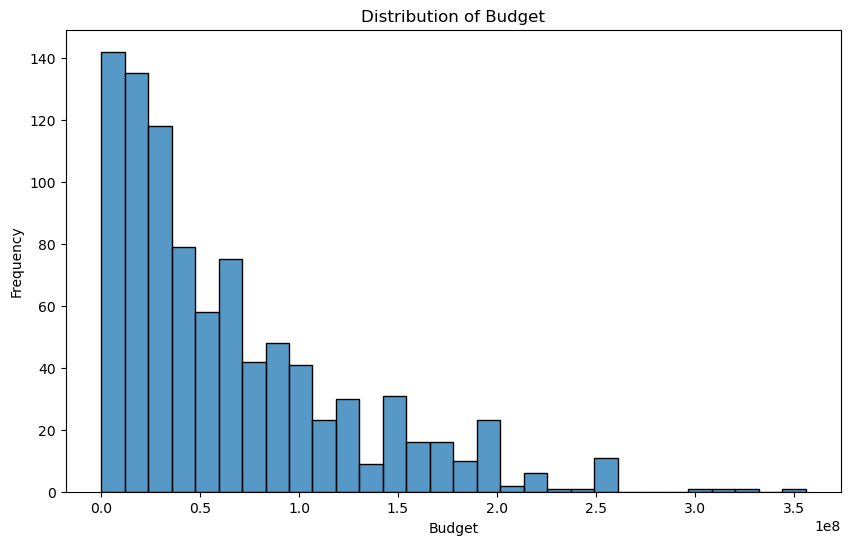

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(df['budget'].dropna(), bins=30, kde=False)
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()


**Data Distribution:** The budget data is right-skewed, with a majority of films having lower budgets.
There are a few high-budget films that are quite distant from the rest.

**Data Imbalance:**
The presence of outliers suggests that while most movies have moderate budgets, a few have exceptionally large budgets.
If the number of high-budget films is relatively small, any predictive model trained on this data may not perform as well when predicting their ratings due to a lack of sufficient examples.

Implications for our model:
- The model may be biased towards predicting the success of lower-budget films more accurately due to the higher frequency of such films in the dataset.

## Genre

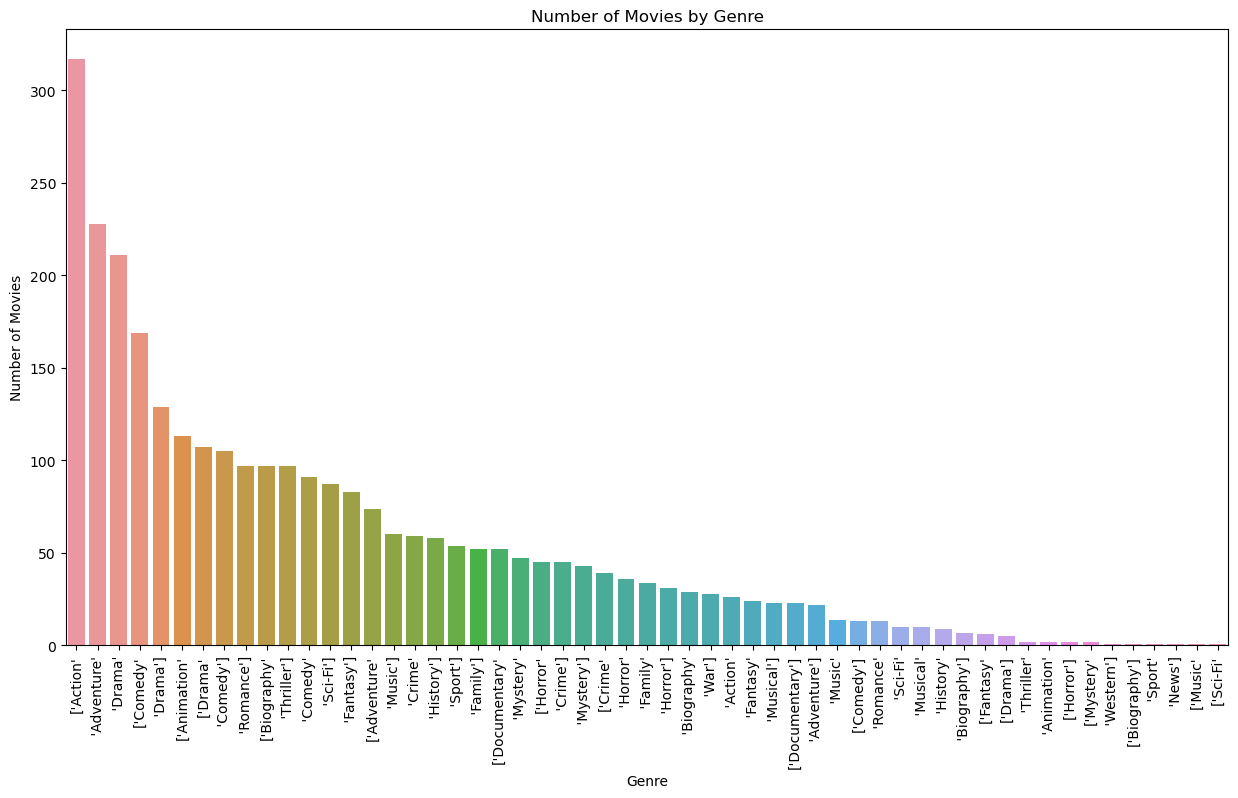

In [47]:
genres_df = df['genres'].str.get_dummies(sep=',')
genres_count = genres_df.sum().sort_values(ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x=genres_count.index, y=genres_count.values)
plt.title('Number of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

**Genre Distribution**: The bar chart shows the number of movies by genre, with a clear preference for certain genres like Action, Drama, and Comedy.
! It is very important to note that most movies are under around 3 genres at once. The presence of movies listed under multiple genres suggests overlapping data points, which can affect the model's understanding of genre-specific success.

Implication for our model:
- It may learn complex patterns due to genre crossover.
- We need to ensure it accounts for multi-genre influences on ratings.
- Genre may not be a standalone predictor but part of a multi-feature interaction.
- We will not keep this as a feature

## Feature Selection:

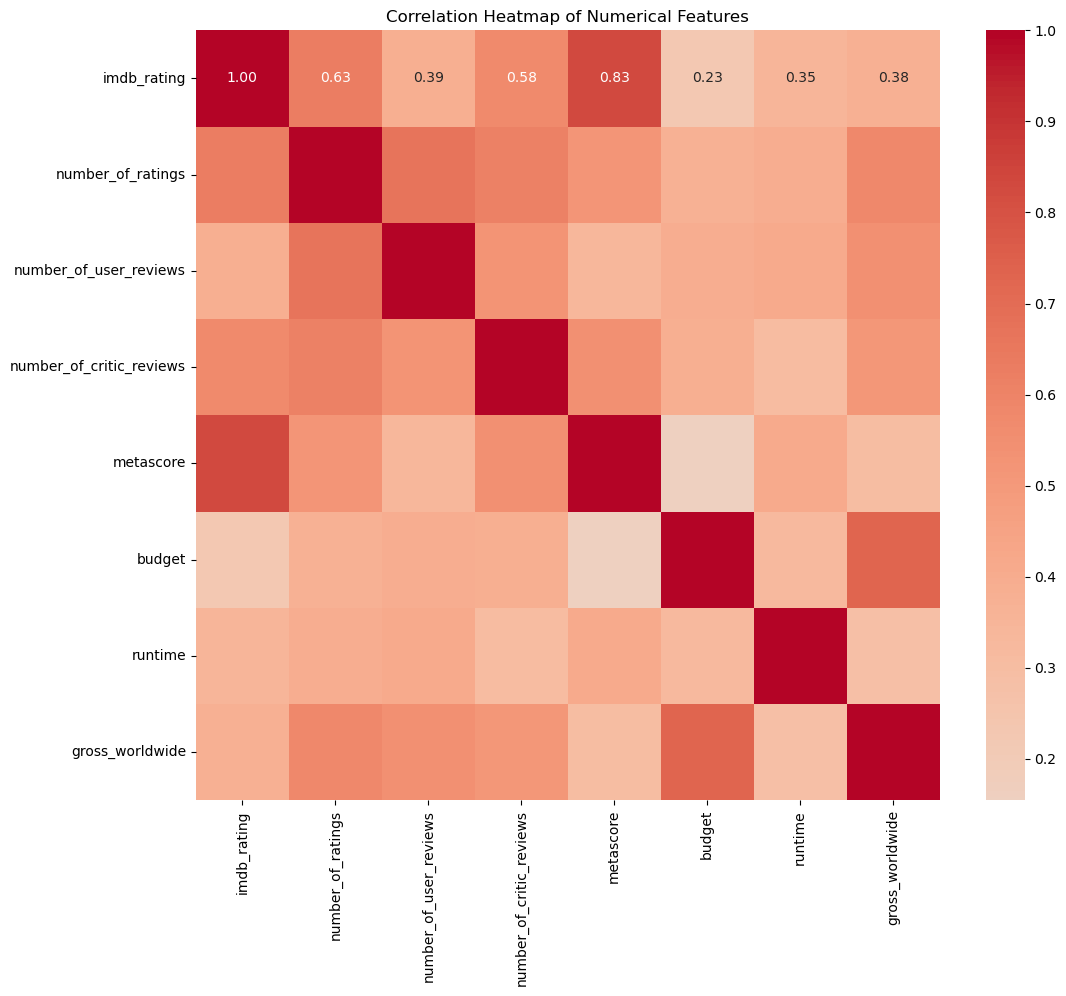

In [81]:
numerical_features = ['imdb_rating', 'number_of_ratings', 'number_of_user_reviews', 'number_of_critic_reviews', 'metascore', 'budget', 'runtime', 'gross_worldwide']
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            annot_kws={"size": 10}, yticklabels=True, xticklabels=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.yticks(rotation=0)
plt.ylim(len(correlation_matrix))  
plt.show()


Feature Correlation:
- As we saw earlier there is a strong correlation between imdb_rating and meta score and we will focus on only using imdb rating as a parameter
- There's also a strong correlation between the budget and the gross worldwide which makes it a good possible predictor of the movie success
- The number of ratings also shows a substantial correlation with the gross worldwide
- We will also keep the number of user reviews and runtime just for fun

Implication for our model:
- We should consider features with stronger correlations for rating predictions, like budget.


# 3. Data Wrangling

## Missing Data

### Null Entries

In [82]:
np.sum(df.isnull())

title                              0
release_date                       0
release_year                       0
rated                             28
runtime                            1
directors                          0
writers                            0
country_of_origin                  0
languages                          0
production_company                 0
imdb_rating                        0
number_of_ratings                  0
number_of_user_reviews             0
number_of_critic_reviews           6
metascore                        107
genres                             0
budget                           146
opening_weekend_us_and_canada    144
gross_us_and_canada              136
gross_worldwide                   60
review_date                        0
review                             0
review_title                       0
dtype: int64

**Rated** (28 missing): Since this is a categorical variable, we will use the most frequent value (mode) imputation because it's likely that the rating distribution has a common class that occurs more often than others.

**Runtime** (2 missing): As the earlier graph shows the runtime is roughly normally distributed so we'll handle it with mean imputation

**Number of critic reviews** (6 missing): The data is right-skewed. A median imputation will work.

**Metascore** (107 missing): Given this is a numerical score likely to have a central tendency, we could use either use mean or median imputation. Since the distribution of Metascore is close to being normally distributed, mean imputation should work fine. doesnt really matter because we are dropping this feature

**Budget** (146 missing):
Given the boxplot visualization for the movie budgets, it's clear that the budget data is right-skewed with several outliers indicating a number of high-budget films. This means median imputation is more suitable than mean imputation because the median is less affected by extreme values and will not distort the central tendency of the budget distribution.

**Opening Weekend Gross (US and Canada)** (144 missing): As the earlier histograms show the data right-skewed. A median imputation would again be a reasonable choice.

**Gross US and Canada** (136 missing): Also is right-skewed and could be handled with median imputation.

**Gross Worldwide** (60 missing): Again, is right-skewed and could be handled with median imputation.

In [83]:
# Mode imputation for 'rated'
mode_rated = df['rated'].mode()[0]
df['rated'].fillna(mode_rated, inplace=True)

# Mean imputation for 'runtime'
mean_runtime = df['runtime'].mean()
df['runtime'].fillna(mean_runtime, inplace=True)

# Median imputation for 'number_of_critic_reviews'
median_number_of_critic_reviews = df['number_of_critic_reviews'].median()
df['number_of_critic_reviews'].fillna(median_number_of_critic_reviews, inplace=True)

# Mean imputation for 'metascore'
mean_metascore = df['metascore'].mean()
df['metascore'].fillna(mean_metascore, inplace=True)

# Median imputation for 'budget'
median_budget = df['budget'].median()
df['budget'].fillna(median_budget, inplace=True)

# Median imputation for 'opening_weekend_us_and_canada'
median_opening_weekend = df['opening_weekend_us_and_canada'].median()
df['opening_weekend_us_and_canada'].fillna(median_opening_weekend, inplace=True)

# Median imputation for 'gross_us_and_canada'
median_gross_us_canada = df['gross_us_and_canada'].median()
df['gross_us_and_canada'].fillna(median_gross_us_canada, inplace=True)

# Median imputation for 'gross_worldwide'
median_gross_worldwide = df['gross_worldwide'].median()
df['gross_worldwide'].fillna(median_gross_worldwide, inplace=True)

In [84]:
np.sum(df.isnull())

title                            0
release_date                     0
release_year                     0
rated                            0
runtime                          0
directors                        0
writers                          0
country_of_origin                0
languages                        0
production_company               0
imdb_rating                      0
number_of_ratings                0
number_of_user_reviews           0
number_of_critic_reviews         0
metascore                        0
genres                           0
budget                           0
opening_weekend_us_and_canada    0
gross_us_and_canada              0
gross_worldwide                  0
review_date                      0
review                           0
review_title                     0
dtype: int64

### Empty Lists

Some columns are of type list and therefore, we should also check for empty lists

In [85]:
def is_empty_list(x):
    return x == [] or x == '[]'
df.applymap(is_empty_list).sum()

title                             0
release_date                      0
release_year                      0
rated                             0
runtime                           0
directors                         0
writers                          19
country_of_origin                 0
languages                         1
production_company                8
imdb_rating                       0
number_of_ratings                 0
number_of_user_reviews            0
number_of_critic_reviews          0
metascore                         0
genres                            0
budget                            0
opening_weekend_us_and_canada     0
gross_us_and_canada               0
gross_worldwide                   0
review_date                       0
review                            0
review_title                      0
dtype: int64

**Writers** (19 missing)
Since the missing percentage is relatively low, imputation is a good choice. Given the complexity of accurately guessing the missing writers without a robust predictive model, using a placeholder like 'Unknown' could be an effective and straightforward approach.

**Languages:** (1 missing)
Similar to writers, the proportion of missing data is very small. You can impute the missing values with the most common language as this is less likely to introduce significant bias, given the minor proportion of missing entries. The assumption here is that the most common language might reasonably represent a typical entry in the dataset.

**Production Company:** (8)
Since production companies can be numerous and diverse, and guessing the missing ones accurately could be difficult, we can use a placeholder like 'Unknown'.

In [87]:
def replace_empty_list(x, replacement):
    if x == [] or x == '[]':
        return replacement
    else:
        return x
df['writers'] = df['writers'].apply(lambda x: replace_empty_list(x, ['Unknown']))

most_common_language = df['languages'].mode()[0]
df['languages'] = df['languages'].apply(lambda x: replace_empty_list(x, most_common_language))


df['production_company'] = df['production_company'].apply(lambda x: replace_empty_list(x, ['Unknown']))


In [88]:
df.applymap(is_empty_list).sum()

title                            0
release_date                     0
release_year                     0
rated                            0
runtime                          0
directors                        0
writers                          0
country_of_origin                0
languages                        0
production_company               0
imdb_rating                      0
number_of_ratings                0
number_of_user_reviews           0
number_of_critic_reviews         0
metascore                        0
genres                           0
budget                           0
opening_weekend_us_and_canada    0
gross_us_and_canada              0
gross_worldwide                  0
review_date                      0
review                           0
review_title                     0
dtype: int64

## Removing Outliers

Removed 58 outliers from budget


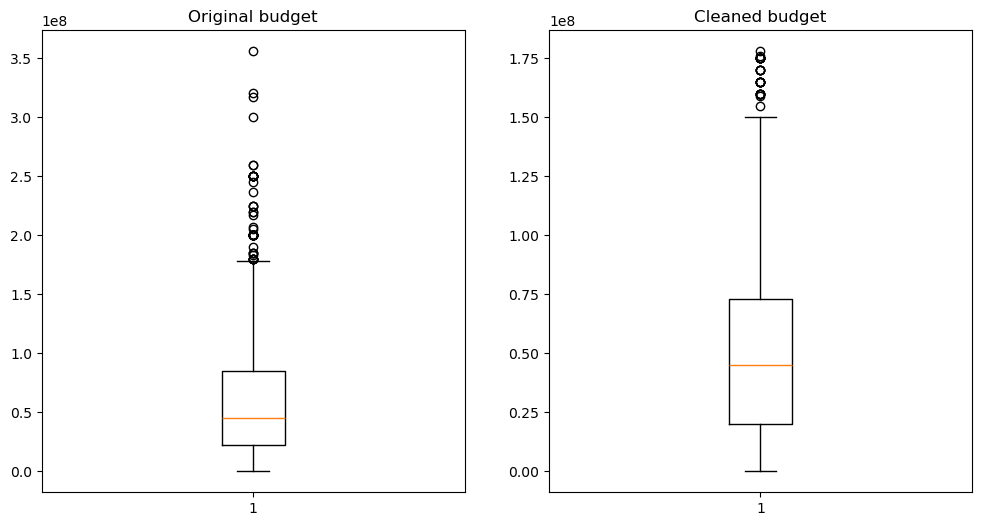

Removed 120 outliers from gross_worldwide


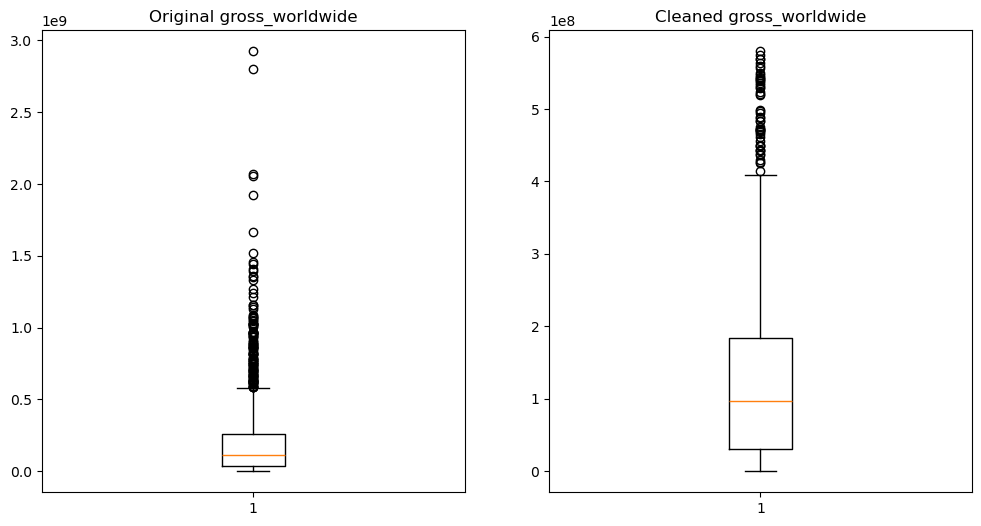

In [89]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_to_check = ['budget', 'gross_worldwide']

for column in columns_to_check:
    original_size = len(df)
    df_cleaned = remove_outliers(df, column)
    cleaned_size = len(df_cleaned)
    print(f'Removed {original_size - cleaned_size} outliers from {column}')

    # Plotting the boxplot before and after removing outliers
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.boxplot(df[column].dropna())
    plt.title(f'Original {column}')

    plt.subplot(1, 2, 2)
    plt.boxplot(df_cleaned[column].dropna())
    plt.title(f'Cleaned {column}')

    plt.show()


## Normalization & scaling

## Categorical Variables

In our project on predicting movie success using IMDB reviews, handling categorical data like movie ratings, genres, and production companies is essential. These features contain critical information but are non-numeric. By applying one-hot encoding, we convert these features into a numerical format, allowing our machine learning models to process and use them effectively. This method ensures the data is presented without implied ordinal relationships, helping the model to make accurate predictions based on the actual impact of each categorical variable.

In [90]:
def convert_categorical(column,df):
    df[column] = df[column].apply(lambda x: eval(x) if isinstance(x, str) else x)
    df = df.explode(column)
    df = pd.get_dummies(df, columns=[column])
    return df

In [91]:
categorical_columns = ['rated']
df = pd.get_dummies(df, columns=categorical_columns)
df.columns

Index(['title', 'release_date', 'release_year', 'runtime', 'directors',
       'writers', 'country_of_origin', 'languages', 'production_company',
       'imdb_rating', 'number_of_ratings', 'number_of_user_reviews',
       'number_of_critic_reviews', 'metascore', 'genres', 'budget',
       'opening_weekend_us_and_canada', 'gross_us_and_canada',
       'gross_worldwide', 'review_date', 'review', 'review_title', 'rated_G',
       'rated_NC-17', 'rated_Not Rated', 'rated_PG', 'rated_PG-13', 'rated_R',
       'rated_TV-14', 'rated_TV-G', 'rated_TV-MA', 'rated_TV-Y7',
       'rated_Unrated'],
      dtype='object')

In [92]:
df = convert_categorical('country_of_origin',df)

In [93]:
df = convert_categorical('languages',df)
df.columns

Index(['title', 'release_date', 'release_year', 'runtime', 'directors',
       'writers', 'production_company', 'imdb_rating', 'number_of_ratings',
       'number_of_user_reviews',
       ...
       'languages_Thai', 'languages_Turkish', 'languages_Ukrainian',
       'languages_Urdu', 'languages_Vietnamese', 'languages_Welsh',
       'languages_Xhosa', 'languages_Yiddish', 'languages_Yoruba',
       'languages_Zulu'],
      dtype='object', length=188)

In [94]:
df = convert_categorical('genres',df)
df.columns

Index(['title', 'release_date', 'release_year', 'runtime', 'directors',
       'writers', 'production_company', 'imdb_rating', 'number_of_ratings',
       'number_of_user_reviews',
       ...
       'genres_Music', 'genres_Musical', 'genres_Mystery', 'genres_News',
       'genres_Romance', 'genres_Sci-Fi', 'genres_Sport', 'genres_Thriller',
       'genres_War', 'genres_Western'],
      dtype='object', length=209)

## Our approach

We are scaling the following features:


In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

In [97]:
def scale_feature(df, feature_name):
    # Applying StandardScaler to the specified feature
    standard_scaler = StandardScaler()
    df[feature_name + '_standard_scaled'] = standard_scaler.fit_transform(df[[feature_name]])

    # Applying MinMaxScaler to the specified feature
    min_max_scaler = MinMaxScaler()
    df[feature_name + '_minmax_scaled'] = min_max_scaler.fit_transform(df[[feature_name]])

    # Applying RobustScaler to the specified feature
    robust_scaler = RobustScaler()
    df[feature_name + '_robust_scaled'] = robust_scaler.fit_transform(df[[feature_name]])

    # Creating the subplot environment with two rows and two columns
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

    # Plotting non-scaled feature on the first subplot
    sns.histplot(df[feature_name], kde=True, ax=axes[0, 0], color='blue')
    axes[0, 0].set_title(f'Distribution of {feature_name} (Not Scaled)')
    axes[0, 0].set_xlabel(feature_name.capitalize())
    axes[0, 0].set_ylabel('Frequency')

    # Plotting standard scaler scaled feature on the second subplot
    sns.histplot(df[feature_name + '_standard_scaled'], kde=True, ax=axes[0, 1], color='red')
    axes[0, 1].set_title(f'Distribution of {feature_name} (Standard Scaler)')
    axes[0, 1].set_xlabel('Standard Scaled ' + feature_name.capitalize())
    axes[0, 1].set_ylabel('Frequency')

    # Plotting MinMax scaler scaled feature on the third subplot
    sns.histplot(df[feature_name + '_minmax_scaled'], kde=True, ax=axes[1, 0], color='green')
    axes[1, 0].set_title(f'Distribution of {feature_name} (MinMax Scaler)')
    axes[1, 0].set_xlabel('MinMax Scaled ' + feature_name.capitalize())
    axes[1, 0].set_ylabel('Frequency')

    # Plotting Robust scaler scaled feature on the fourth subplot
    sns.histplot(df[feature_name + '_robust_scaled'], kde=True, ax=axes[1, 1], color='orange')
    axes[1, 1].set_title(f'Distribution of {feature_name} (Robust Scaler)')
    axes[1, 1].set_xlabel('Robust Scaled ' + feature_name.capitalize())
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

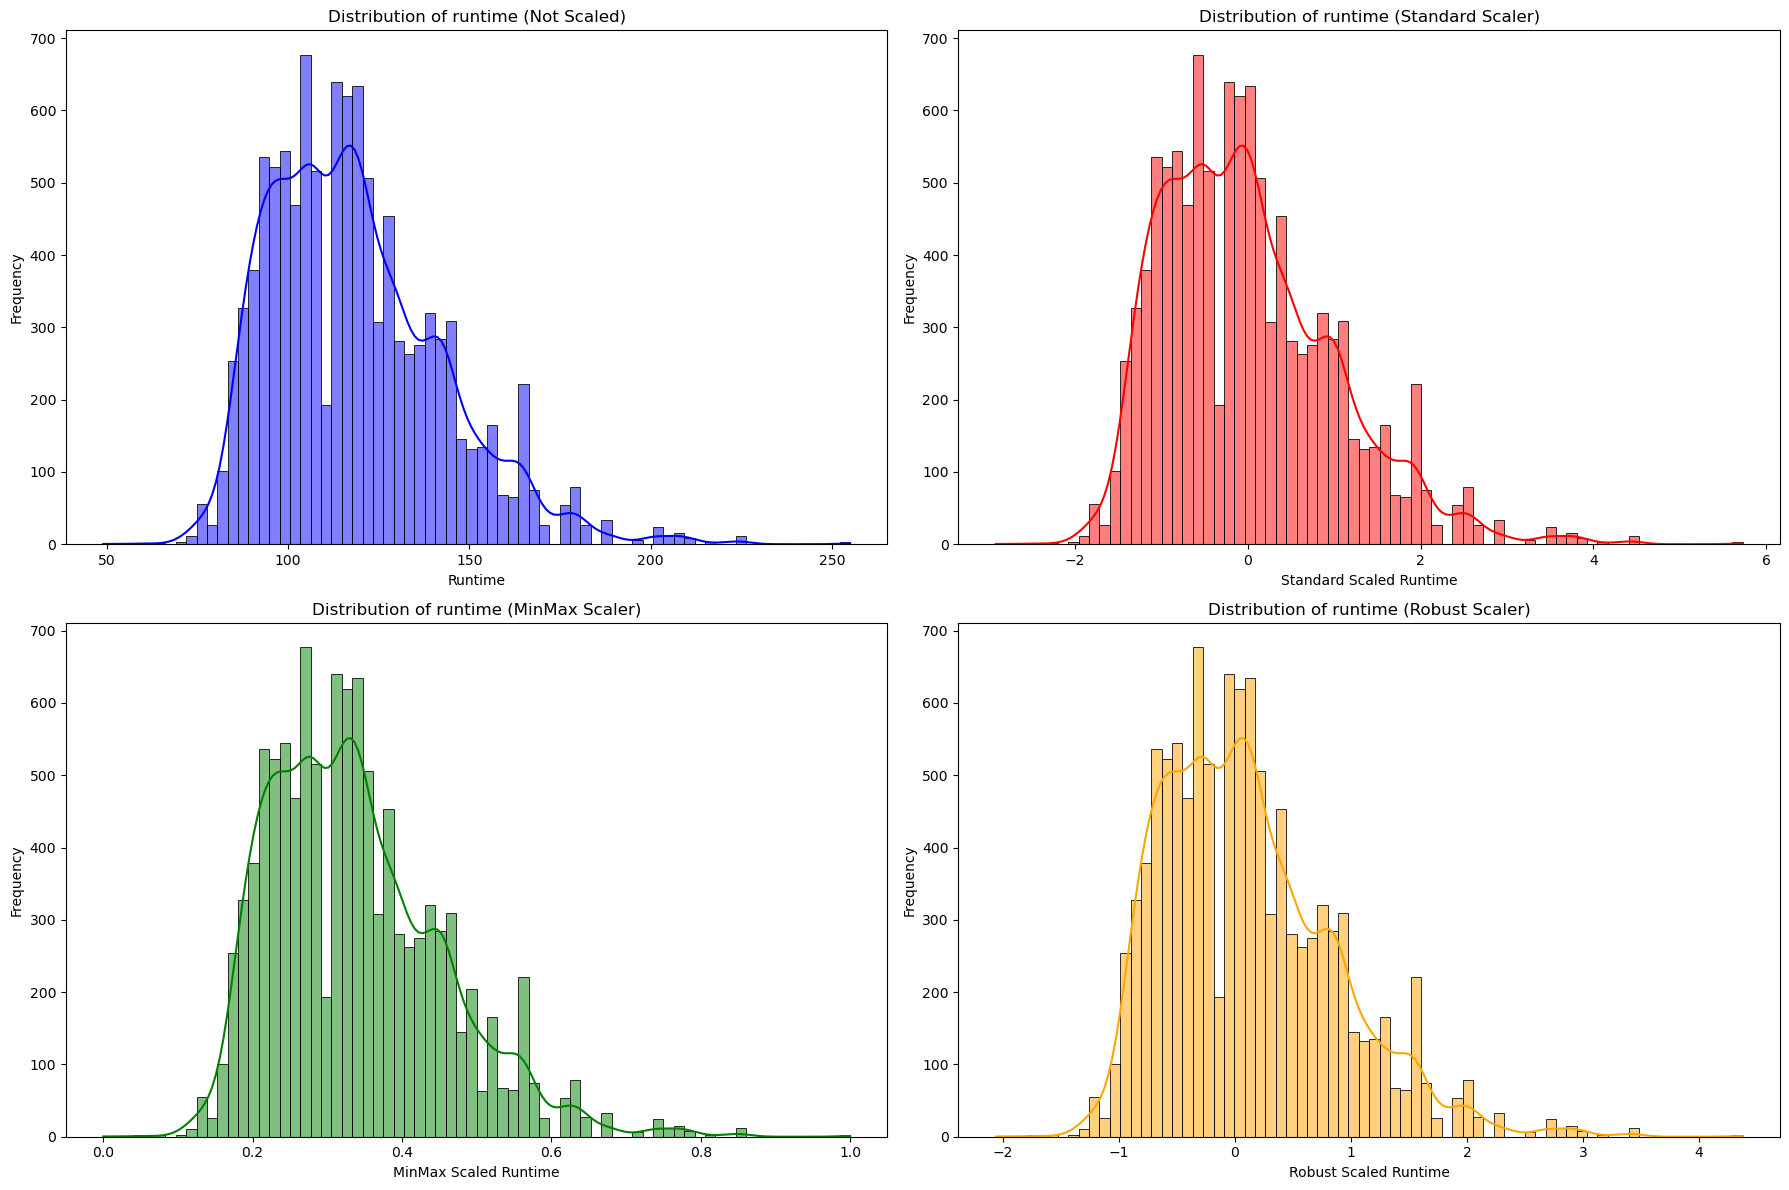

In [98]:
scale_feature(df, 'runtime')

The first plot shows the original runtime distribution, which appears to be slightly right-skewed but relatively normal. Given this, the Standard Scaler, which centers the data around zero and scales it to unit variance, seems to perform well, as the resulting distribution appears normal and centered. However, the MinMax Scaler, which normalizes the data into a [0, 1] range, might be less suitable as it compresses all data points into a narrow range, which could be problematic if new data points fall outside the trained range. The Robust Scaler, which is less influenced by outliers, might not be necessary in this case as the distribution doesn't seem to have significant outliers. Therefore, the Standard Scaler seems to be the best option for this particular dataset, given its relatively normal distribution and lack of significant outliers.

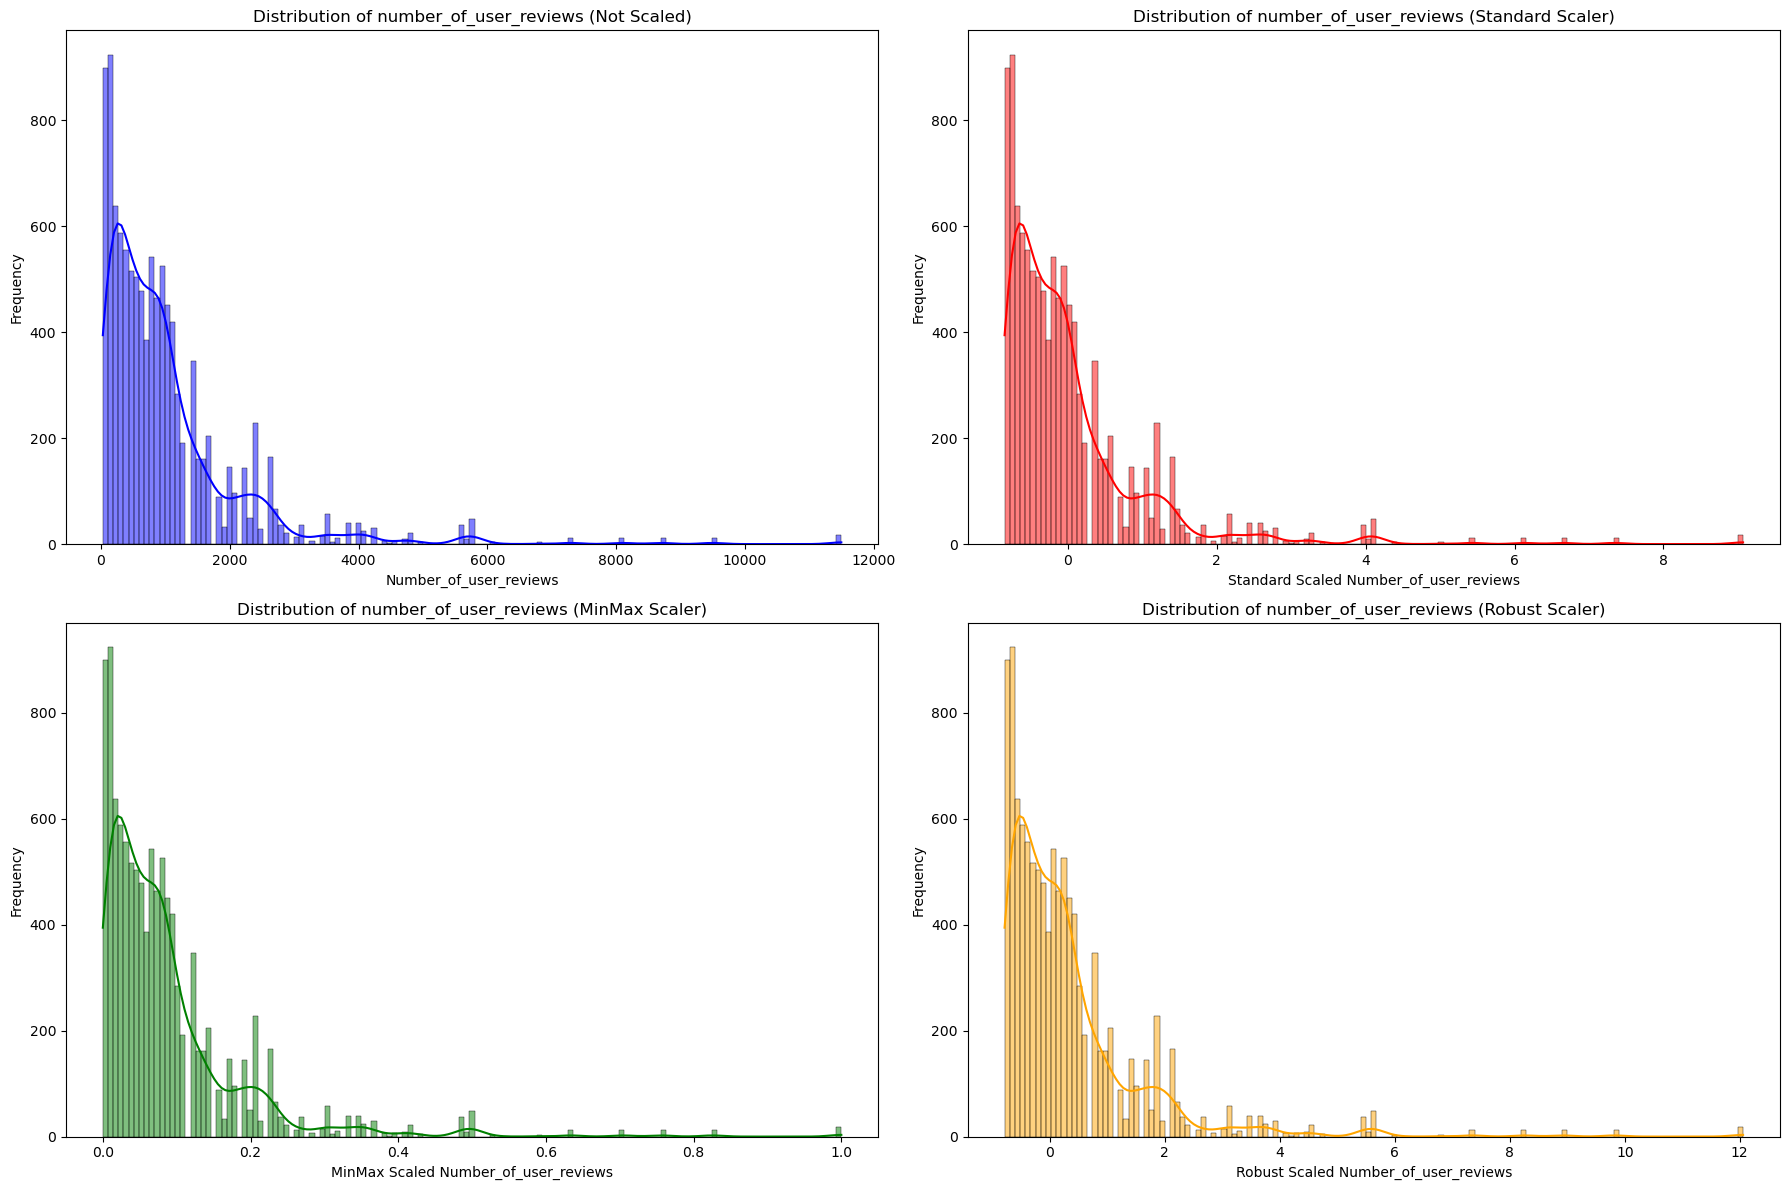

In [99]:
scale_feature(df, 'number_of_user_reviews')

The original distribution of the number of user reviews is highly right-skewed, indicating that most movies receive few reviews while a small number receive a lot. The MinMax Scaler has compressed all values into the [0, 1] range, but the right skewness is still present. The Standard Scaler is not the best choice in this scenario because it doesn't correct for the skewness; it merely centers the data, resulting in a distribution that still has a pronounced right tail (we need Gaussian distribution initially). The Robust Scaler, which is less influenced by outliers, makes the data more symmetric and could be a more appropriate choice here as it reduces the influence of the extreme values. However, a transformation aimed at reducing skewness, like a logarithmic transformation, might be more suitable to normalize the distribution in such skewed data.

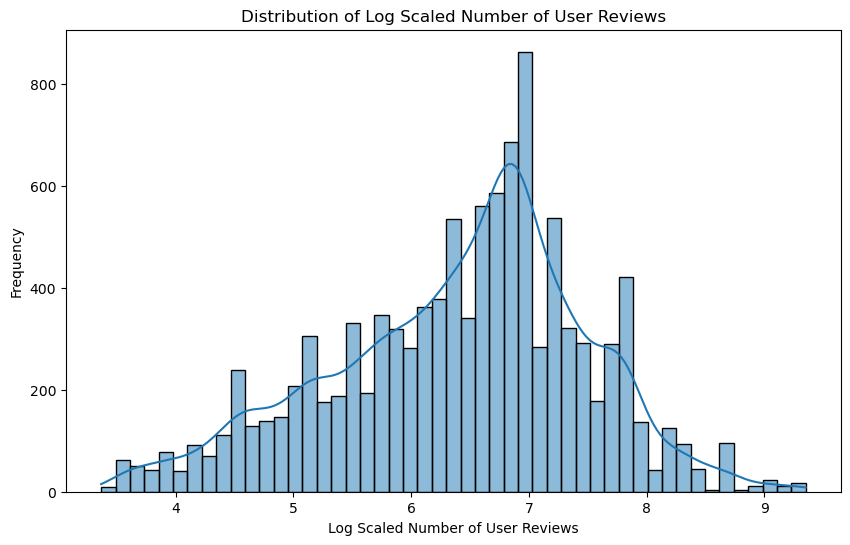

In [100]:
# Apply log scaling
df['number_of_user_reviews_log_scaled'] = np.log1p(df['number_of_user_reviews'])

# Plot the log-scaled number of user reviews
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_user_reviews_log_scaled'], kde=True)
plt.title('Distribution of Log Scaled Number of User Reviews')
plt.xlabel('Log Scaled Number of User Reviews')
plt.ylabel('Frequency')
plt.show()



The log-scaled histogram of the number of user reviews reveals a more symmetric and normal-like distribution compared to the original right-skewed distribution. The logarithmic transformation is particularly effective in these cases because it reduces the impact of extreme higher values, which are common in right-skewed data, by scaling them down more significantly than the lower values. This transformation tends to spread out the clumps of data on the lower end while pulling in the long tail on the higher end, making the distribution more uniform and suitable for linear modeling techniques that assume normally distributed data.

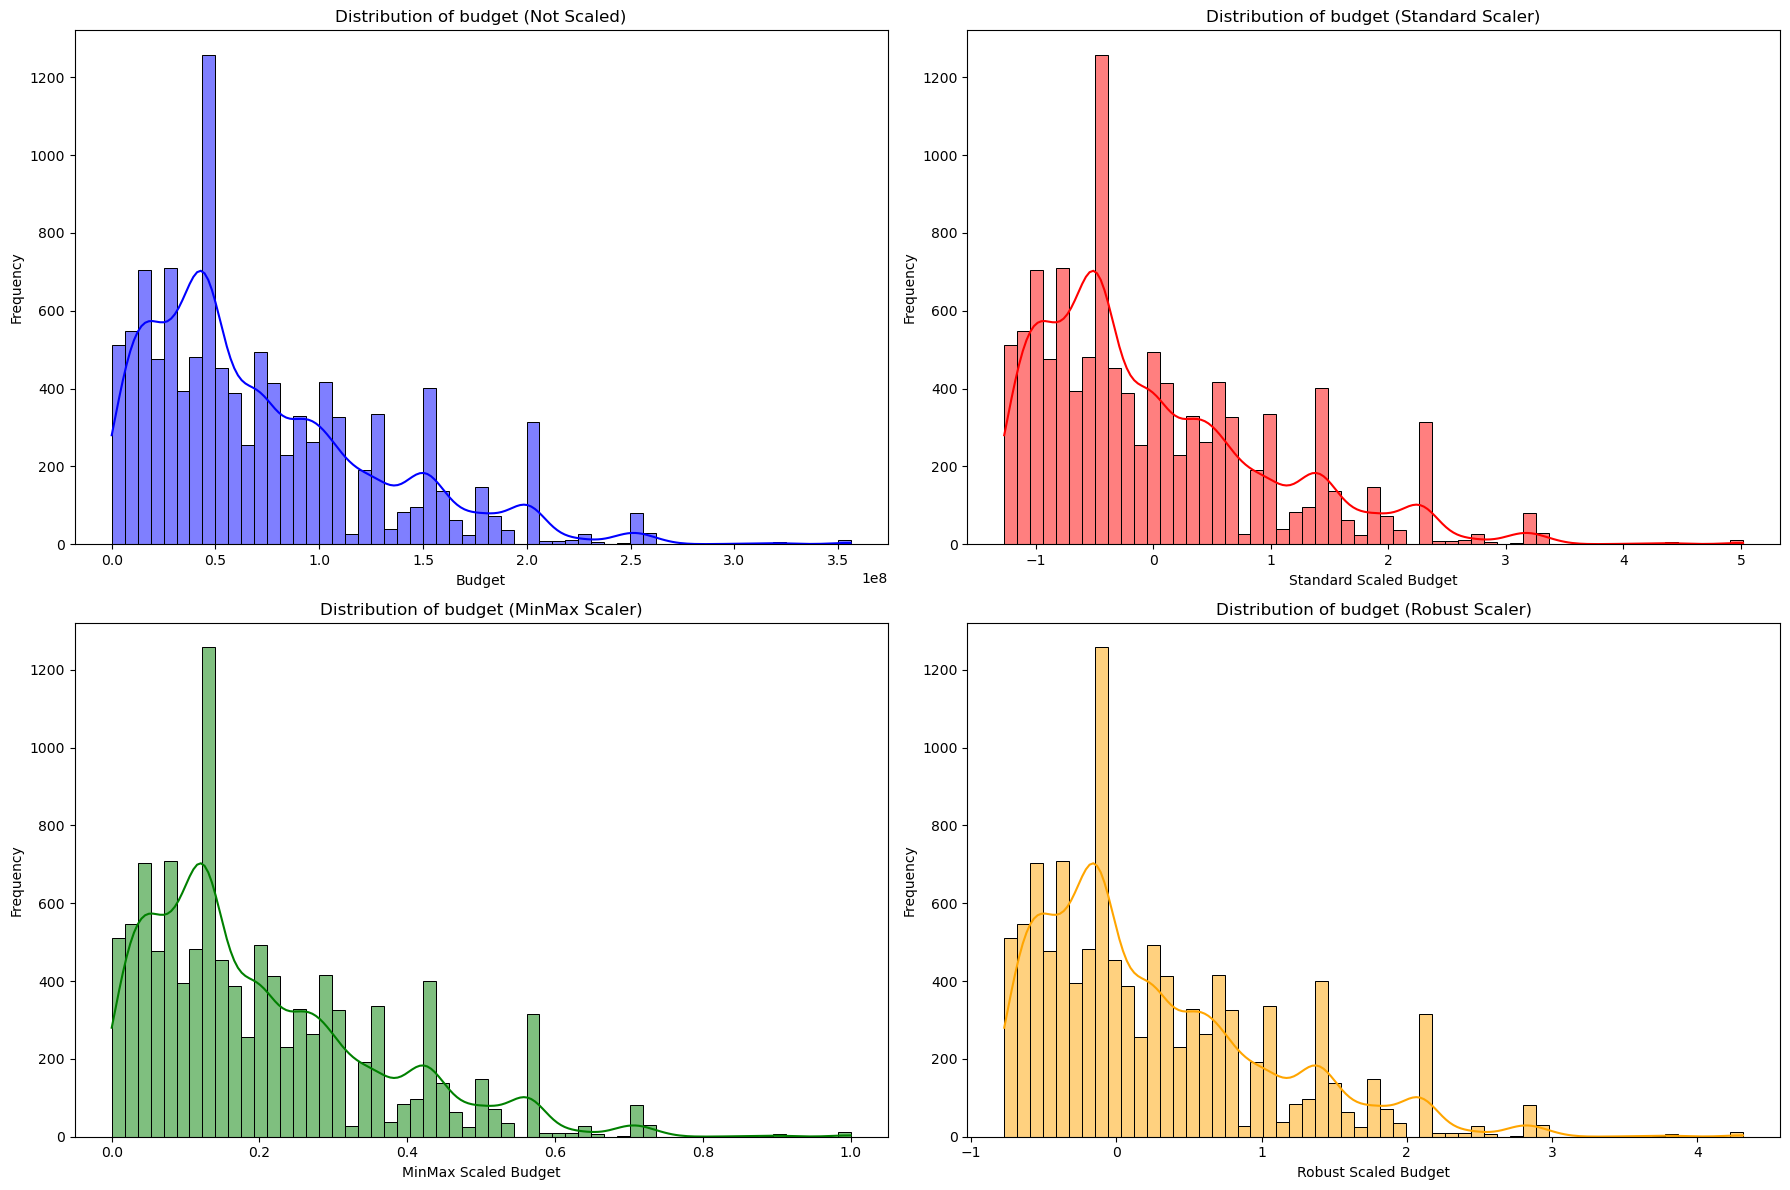

In [101]:
scale_feature(df, 'budget')

In the case of budget, the original data seems to be heavily right-skewed, indicating that a few movies have exceptionally high budgets while the majority have comparatively low budgets. The MinMax Scaler has transformed the data into a fixed range between 0 and 1, but it has preserved the skewness, potentially compressing the majority of data points into a small part of the range. The Standard Scaler has centralized the data, but the distribution remains right-skewed, with extreme budget values likely exerting an outsized influence on model training.

The Robust Scaler has reduced the impact of extreme values by scaling using the interquartile range, which could make it a good choice for dealing with outliers. However, the log transformation, which is not shown here but discussed previously for the user reviews, would likely be even more effective for budget. It would reduce the skew by compressing the large budget values, yielding a distribution that is more symmetric and potentially more suitable for linear models that assume data is normally distributed.

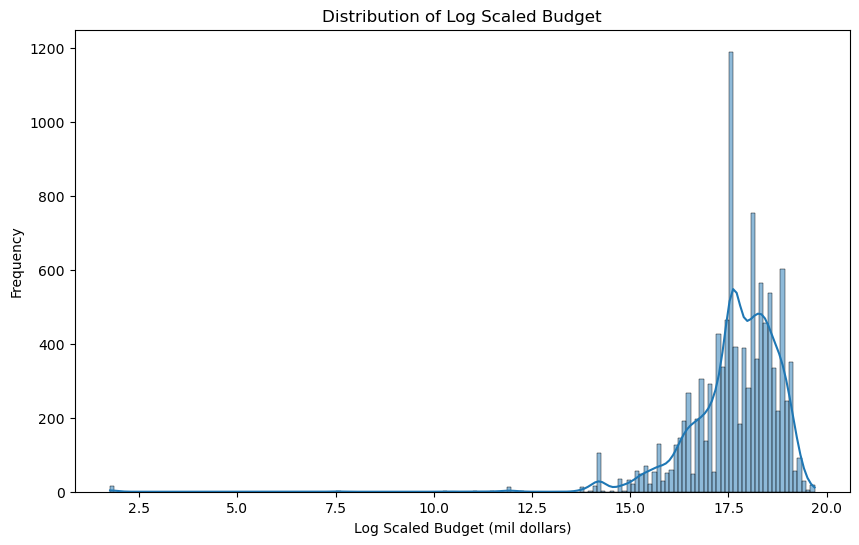

In [102]:
# Apply log scaling
df['budget_log_scaled'] = np.log1p(df['budget'])

# Plot the log-scaled budget
plt.figure(figsize=(10, 6))
sns.histplot(df['budget_log_scaled'], kde=True)
plt.title('Distribution of Log Scaled Budget')
plt.xlabel('Log Scaled Budget (mil dollars)')
plt.ylabel('Frequency')
plt.show()



The log transformation has significantly reduced the right skewness of the budget data, resulting in a distribution that appears more symmetric and bell-shaped, which is closer to a normal distribution

# 4. Feature Engineering

### Before we create the new features here is a recap of which feature we decided to keep from the scraped features:



*   imdb_rating
*  number_of_user_reviews (log scaled)
* runtime (standard scaled)
*   Budget (log scaled)
* Languages (one-hot encoding)
*  Genres (one-hot encoding)
* Rated (one-hot encoding)




### To create more meaningful features from our dataset and improve the accuracy of predicting IMDB ratings, we approached feature engineering by:
- Extracting text based features from review data such as, calculating sentiment scores using pre-trained sentiment analysis' models such as BERT and frequencies of positive and negative words in a review. We also utilized word embeddings, which transform textual data into dense vector representations for a more nuanced analysis.
- Counting the presence of top production companies.











## Extraction of New Features

In [103]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.util import ngrams
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from joblib import Parallel, delayed


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jullia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jullia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jullia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Preprocess Review Features

Before being able to use sentiment analysis tools such as VADER and Flair we first need to preprocess the review data. So we remove non-ascii characters, punctuations, and only keep digits and letters.

In [104]:
def clean_review(review):
    # Step 0 - Remove HTML line break tags
    review = re.sub(r'<br\s*/?>', ' ', review)

    #Step 1 - normalize case
    review = review.lower()
    #Step 2 - remove links
    review = re.sub(r'(?:http|https)://t\.co/\w{10}', ' ', review)

    #Step 3 - Remove any non-ascii characters
    review =  re.sub(r'[^\x00-\x7F]+',' ', review)

    #Step 4 - check for apostrophes
    review = re.sub(r"'s", "", review)
    review = review.replace("'", "")

    #Step 5 - Remove hyphens
    review = review.replace('-', ' ')

    #Step 6 - Remove periods and colons
    review = review.replace('.', ' ')
    review = review.replace(',', ' ')
    review = review.replace(':', ' ')
    review = review.replace(';', ' ')
    review = review.replace('!', ' ')

    #Step 7 - Keep letters and digits only
    review = re.sub(r'[^\x00-\x7F]+', ' ', review)

    #Step 8 - Tokenize
    tokenize = nltk.word_tokenize(review)

    #Step 9 - Lemmatize
    lemmatizer= nltk.stem.wordnet.WordNetLemmatizer()
    lemmatize_text = map(lambda x: lemmatizer.lemmatize(x), tokenize)

    #Step 10 - Remove stop words
    stopwords = set(nltk.corpus.stopwords.words('english'))
    remove_stop = list(filter(lambda x: x not in stopwords, lemmatize_text))

    #Step 11 - Remove any empty strings from list
    processed_list = list(filter(lambda a: a != "", remove_stop))

    processed_string = " ".join(processed_list)

    return processed_string

In [105]:
df["clean_review_text"] = df["review"].apply(lambda x: [clean_review(i) for i in x] if isinstance(x, list) else x)
df["clean_review_title_text"] = df["review_title"].apply(lambda x: [clean_review(i) for i in x] if isinstance(x, list) else x)

### Top Production Company Count


In this section, we count the number popular production companies that were involved in making each movie. We believe this is important because the overall quality, and thus its success, of a movie highly depends on the production companies behind it.

In [112]:
# Convert the 'production_company' strings into actual lists and remove extra quotes
df['production_company'] = df['production_company'].apply(lambda x: [i.replace("'", "").strip() for i in x.strip('[]').split(',')] if isinstance(x, str) else x)

# Count the number of popular companies for each movie, case-insensitive
df['top_prod_company_count'] = df['production_company'].apply(lambda x: len([company.lower() for company in x if company.lower() in map(str.lower, production_companies_list)]))

In [113]:
df['top_prod_company_count'].value_counts()

top_prod_company_count
1    5133
0    4674
2     983
3      30
Name: count, dtype: int64

### VADER Score

The VADER algorithm assigns a sentiment score to each piece of text, indicating the positivity, negativity, or neutrality of the sentiment. We will use the compound score, which is calculated by summing the normalized scores of each word in the text and then applying a normalization technique. Scores range from -1 (extremely negative) to 1 (extremely positive), with scores closer to -1 indicating more negative sentiment and scores closer to 1 indicating more positive sentiment.

In [106]:
analyzer = SentimentIntensityAnalyzer()
df['review_vader_score'] = df['clean_review_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['review_title_vader_score'] = df['clean_review_title_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

### Frequency of Positive and Negative Words

 In this section we add the the frequency of positive and negative words of each review as we think it provides valuable insights into the overall tone and perception of each movie review.

In [109]:
with open('negative-words.txt', 'r') as file:
    negative_words = file.read().splitlines()

with open('positive-words.txt', 'r') as file:
    positive_words = file.read().splitlines()

def count_and_list_words(review, neg_words, pos_words):
    review_words = review.split()
    total_words = len(review_words)
    neg_list = [word for word in review_words if word in neg_words]
    pos_list = [word for word in review_words if word in pos_words]
    neg_freq = len(neg_list) / total_words if total_words > 0 else 0
    pos_freq = len(pos_list) / total_words if total_words > 0 else 0
    return neg_freq, pos_freq, neg_list, pos_list

# Join the words in the reviews into strings
df['clean_review_text'] = df['clean_review_text'].apply(' '.join)

# Parallel processing
results = Parallel(n_jobs=-1)(delayed(count_and_list_words)(review, negative_words, positive_words) for review in df['clean_review_text'])

# Unpack results and assign to DataFrame
df['negative_word_freq'], df['positive_word_freq'], df['negative_words'], df['positive_words'] = zip(*results)

### Word-Embeddings

We now use pre-trained GloVe embeddings to enrich textual data representations. This is because GloVe embeddings can capture semantic relationships between words in a given corpus, so this will represent the review textual data in a contextually relevant manner. We go through each review and map individual words to their embeddings using a pre-converted Word2Vec model. The embeddings are then aggregated to obtain a single embedding representation for each text, computed as the mean of all word embeddings present. We also normalizes the embeddings for uniformity across different textual features. 



In [114]:
from gensim.models import KeyedVectors
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_file, word2vec_output_file)

word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file)

# Map words to embeddings and aggregate
df['review_embeddings'] = df['clean_review_text'].apply(lambda words: np.mean([word_vectors[word] for word in words if word in word_vectors.key_to_index], axis=0))
df['title_embeddings'] = df['clean_review_title_text'].apply(lambda words: np.mean([word_vectors[word] for word in words if word in word_vectors.key_to_index], axis=0))

# Normalize embeddings
df['review_embeddings_normalized'] = df['review_embeddings'].apply(lambda vec: vec / np.linalg.norm(vec))
df['title_embeddings_normalized'] = df['title_embeddings'].apply(lambda vec: vec / np.linalg.norm(vec))

/var/folders/6d/82lm6dh113d3dzhpbgts96tc0000gn/T/ipykernel_14625/235384648.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)
/Users/jullia/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jullia/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


###

### BERT for Sentiment Analysis

In this section we use BERT-based sentiment analysis as this would provide valuable insights into the emotional tone and subjective opinions expressed within movie reviews. By quantifying sentiment, we create a meaningful feature that reflects audience perceptions and reactions towards movies.



In [ ]:
from transformers import pipeline, AutoTokenizer

# Initialize the sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline('text-classification', model=model_name)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_text(reviews):
    # Ensure the input is a list of reviews
    if not isinstance(reviews, list):
        reviews = [reviews]

    # Tokenize each review and truncate to the maximum length
    preprocessed_reviews = [' '.join(tokenizer.tokenize(review)[:512]) for review in reviews]

    return preprocessed_reviews

# Apply the function to the 'review' column
df['preprocessed_reviews'] = df['review'].apply(preprocess_text)

# Apply the classifier to each preprocessed review, get the sentiment, and calculate the median sentiment
df['median_sentiment'] = df['preprocessed_reviews'].apply(lambda reviews: np.median([classifier(review[:512])[0]['score'] for review in reviews]))

Token indices sequence length is longer than the specified maximum sequence length for this model (8287 > 512). Running this sequence through the model will result in indexing errors


## Assessing Relevancy of Features

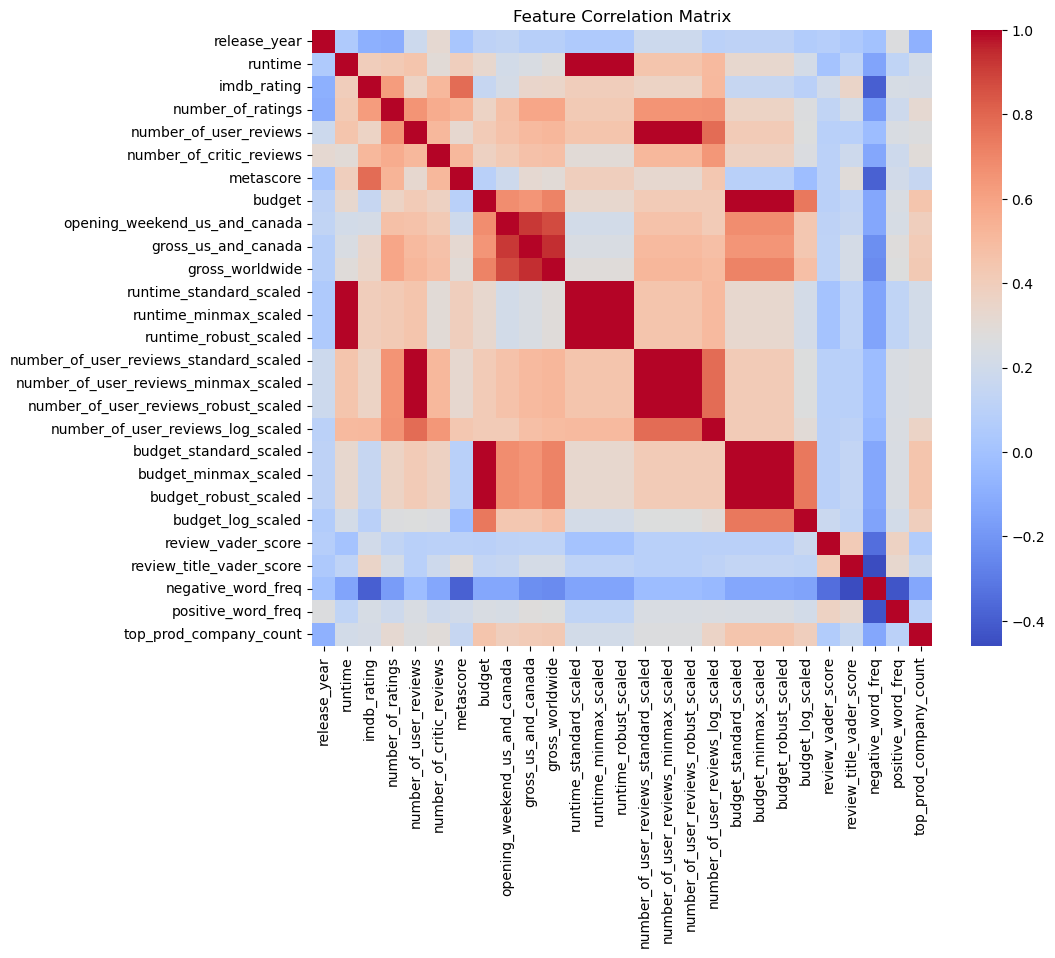

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

corr_threshold = 0.7

highly_correlated = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            highly_correlated.add((feature_i, feature_j))



## Final List of Features:

*   imdb_rating
*  number_of_user_reviews (log scaled)
* runtime (standard scaled)
*   budget (log scaled)
* languages (one-hot encoding) (might be drpped later on depending on the model)
*  genres (one-hot encoding)
*  rated (one-hot encoding)
* median_sentiment (BERT) (we can see somewhat of a negative correlation with gross worldwide)
* negative_word_frequency
* positive_word_frequency
* review_vader_score
* review_title_vader_score
* review_embeddings_normalized
* title_embeddings_normalized
* top_prod_company_count

In [78]:
df.columns

Index(['title', 'release_date', 'release_year', 'runtime', 'directors',
       'writers', 'production_company', 'imdb_rating', 'number_of_ratings',
       'number_of_user_reviews',
       ...
       'title_embeddings', 'review_embeddings_normalized',
       'title_embeddings_normalized', 'negative_word_freq',
       'positive_word_freq', 'negative_words', 'positive_words',
       'top_prod_company_count', 'review_vader_score',
       'review_title_vader_score'],
      dtype='object', length=235)

In [79]:
columns_to_drop = [
    'title', 'release_date', 'release_year', 'directors',
    'writers', 'production_company', 'number_of_user_reviews_standard_scaled',
    'number_of_user_reviews_minmax_scaled', 'number_of_user_reviews_robust_scaled',
    'budget_standard_scaled', 'budget_minmax_scaled', 'budget_robust_scaled',
    'runtime_minmax_scaled', 'runtime_robust_scaled', 'runtime', 'number_of_ratings', 'number_of_user_reviews',
    'number_of_critic_reviews', 'metascore', 'budget',
    'opening_weekend_us_and_canada', 'gross_us_and_canada', 'review_date', 'review', 'review_title', 'clean_review_text',
    'clean_review_title_text', 'review_embeddings', 'title_embeddings', 'negative_words', 'positive_words', 'preprocessed_reviews'
]

df = df.drop(columns=columns_to_drop)
# dropping country columns
columns_to_drop_countries = [col for col in df.columns if col.startswith('country_of_origin')]

df= df.drop(columns=columns_to_drop_countries)
df.columns

Index(['imdb_rating', 'gross_worldwide', 'rated_G', 'rated_NC-17',
       'rated_Not Rated', 'rated_PG', 'rated_PG-13', 'rated_R', 'rated_TV-14',
       'rated_TV-G',
       ...
       'number_of_user_reviews_log_scaled', 'budget_log_scaled',
       'median_sentiment', 'review_embeddings_normalized',
       'title_embeddings_normalized', 'negative_word_freq',
       'positive_word_freq', 'top_prod_company_count', 'review_vader_score',
       'review_title_vader_score'],
      dtype='object', length=143)

In [75]:
df.columns

Index(['imdb_rating', 'gross_worldwide', 'rated_G', 'rated_NC-17',
       'rated_Not Rated', 'rated_PG', 'rated_PG-13', 'rated_R', 'rated_TV-14',
       'rated_TV-G',
       ...
       'number_of_user_reviews_log_scaled', 'budget_log_scaled',
       'median_sentiment', 'review_embeddings_normalized',
       'title_embeddings_normalized', 'negative_word_freq',
       'positive_word_freq', 'top_prod_company_count', 'review_vader_score',
       'review_title_vader_score'],
      dtype='object', length=143)

In [80]:
df.to_csv('Finaldataset.csv', index=False)